In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
sys.path.append('./src/analysis')
sys.path.append('./src/data_handling')
sys.path.append('./src/modeling')
sys.path.append('./src/prediction')
sys.path.append('./src/visualization')
from analyzer import FeatureAnalyzer
from selector import FeatureSelector
from aggregator import DataAggregator
from feature_engineer import BatteryFeatureEngineer
from reader import BatteryDataReader
from cross_validator import CrossValidator
from evaluator import ModelEvaluator
from trainer import ModelTrainer
from predictor import Predictor
from visualizer import ResultVisualizer


In [2]:
battery_ids = ['B0005', 'B0006', 'B0007', 'B0018']
ACTUAL_DATA_DIR = "./dataset/"

# Update config for feature engineering
fe_configuration = {
    # Update config
}

# Init object
aggregator_df = DataAggregator(
    battery_ids=battery_ids,
    data_dir=ACTUAL_DATA_DIR,
    fe_config=fe_configuration
)

In [3]:
# Aggregator data
aggregator_df.aggregate(force_rerun=True)

# Get data aggregator
df_combined = aggregator_df.get_combined_data()

# Check data combined
df_combined.head()


--- Starting Data Aggregation for Batteries: ['B0018', 'B0005', 'B0006', 'B0007'] ---


Aggregating Batteries:   0%|          | 0/4 [00:00<?, ?it/s]


--- Processing: B0018 ---
--- Loading data for battery: B0018 ---
  Successfully loaded: capacity_B0018.csv
  Successfully loaded: charge_B0018.csv
  Successfully loaded: discharge_B0018.csv
--- Data loading process completed for B0018 ---
  Ensuring numeric types for B0018...
--- Starting Feature Engineering process for B0018 ---
  Calculating SOH/RUL for B0018...
    Note: Battery B0018 did not reach EoL threshold (1.30 Ah). Using 133 for RUL.
  Engineering discharge features for B0018...


  Engineering charge features for B0018...


Aggregating Batteries:  25%|██▌       | 1/4 [00:00<00:01,  2.21it/s]

  Merging features for B0018...
  Handling NaNs for B0018...
--- Feature Engineering process finished for B0018 ---
  Successfully processed B0018. Shape: (132, 13)

--- Processing: B0005 ---
--- Loading data for battery: B0005 ---
  Successfully loaded: capacity_B0005.csv
  Successfully loaded: charge_B0005.csv
  Successfully loaded: discharge_B0005.csv
--- Data loading process completed for B0005 ---
  Ensuring numeric types for B0005...
--- Starting Feature Engineering process for B0005 ---
  Calculating SOH/RUL for B0005...
  Engineering discharge features for B0005...


  Engineering charge features for B0005...


Aggregating Batteries:  50%|█████     | 2/4 [00:01<00:01,  1.60it/s]

  Merging features for B0005...
  Handling NaNs for B0005...
--- Feature Engineering process finished for B0005 ---
  Successfully processed B0005. Shape: (168, 13)

--- Processing: B0006 ---
--- Loading data for battery: B0006 ---
  Successfully loaded: capacity_B0006.csv
  Successfully loaded: charge_B0006.csv
  Successfully loaded: discharge_B0006.csv
--- Data loading process completed for B0006 ---
  Ensuring numeric types for B0006...
--- Starting Feature Engineering process for B0006 ---
  Calculating SOH/RUL for B0006...
  Engineering discharge features for B0006...


  Engineering charge features for B0006...


Aggregating Batteries:  75%|███████▌  | 3/4 [00:01<00:00,  1.53it/s]

  Merging features for B0006...
  Handling NaNs for B0006...
--- Feature Engineering process finished for B0006 ---
  Successfully processed B0006. Shape: (168, 13)

--- Processing: B0007 ---
--- Loading data for battery: B0007 ---
  Successfully loaded: capacity_B0007.csv
  Successfully loaded: charge_B0007.csv
  Successfully loaded: discharge_B0007.csv
--- Data loading process completed for B0007 ---
  Ensuring numeric types for B0007...
--- Starting Feature Engineering process for B0007 ---
  Calculating SOH/RUL for B0007...
    Note: Battery B0007 did not reach EoL threshold (1.32 Ah). Using 169 for RUL.
  Engineering discharge features for B0007...


  Engineering charge features for B0007...


Aggregating Batteries: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]

  Merging features for B0007...
  Handling NaNs for B0007...
--- Feature Engineering process finished for B0007 ---
  Successfully processed B0007. Shape: (168, 13)

--- Concatenating data from all processed batteries ---
Combined DataFrame shape: (636, 13)
Unique batteries in combined data: ['B0018' 'B0005' 'B0006' 'B0007']

--- Performing final NaN check and fill on combined data ---
No NaNs found in the combined data after individual processing.
--- Data Aggregation Finished ---


,cycle,capacity,SOH,RUL,Discharge_V_median,Discharge_V_skew,Discharge_T_delta,Discharge_T_std,Charge_T_std,Time_CC_phase,Time_CV_phase,CV_I_end,battery_id
0,1,1.855005,100.000000,132,3.526933,-0.947780,14.282283,3.393883,0.820400,296.578,7411.750,0.004135,B0018
1,2,1.843196,99.363398,131,3.533510,-1.043131,13.835093,3.279763,1.268922,2796.594,7523.328,-0.001571,B0018
2,3,1.839602,99.169669,130,3.535711,-1.050840,13.784999,3.267322,1.312674,2806.203,7533.282,0.001311,B0018
3,4,1.830674,98.688364,129,3.535111,-1.013628,13.834936,3.290899,1.318874,2788.610,7554.031,0.001190,B0018
4,5,1.832700,98.797614,128,3.540578,-1.038804,13.796394,3.303798,1.203835,2750.344,7581.500,-0.001253,B0018


In [4]:
def replace_outlier(df_processed,column_names, thresholds):
    for column_name, threshold in zip(column_names, thresholds):
        indices_below_threshold = df_processed.index[df_processed[column_name] < threshold].tolist()

        print(f"\nCác index có giá trị < {threshold}: {indices_below_threshold}")

        for idx in indices_below_threshold:
            # Kiểm tra xem có phải là hàng cuối cùng không
            if idx < len(df_processed) - 1:
                value_after = df_processed.loc[idx + 1, column_name]
                print(f" - Tại index {idx}, giá trị gốc là {df_processed.loc[idx, column_name]}.Thay bằng : {value_after}")
                df_processed.loc[idx, column_name] = value_after

In [8]:
df_combined_copy = df_combined.copy()

In [11]:
replace_outlier(df_combined_copy, ['Time_CV_phase', 'Time_CC_phase', 'Charge_T_std'],[6000, 500, 0.7])


Các index có giá trị < 6000: []

Các index có giá trị < 500: []

Các index có giá trị < 0.7: []


In [12]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [13]:
features_to_scale = ['Discharge_V_median', 'Discharge_V_skew','Discharge_T_delta','Discharge_T_std','Charge_T_std','Time_CC_phase'
                    ,'Time_CV_phase']
df_scaled = df_combined_copy.copy()
# --- A. StandardScaler ---
print("\n--- Sử dụng StandardScaler ---")
scaler_std = StandardScaler()
# Fit và transform trực tiếp trên các cột đã chọn của df_scaled
df_scaled[features_to_scale] = scaler_std.fit_transform(df_scaled[features_to_scale])
print("DataFrame sau khi chuẩn hóa bằng StandardScaler:")
print(df_scaled)
# In ra mean và std của các cột đã chuẩn hóa để kiểm tra
print("Mô tả thống kê các cột đã chuẩn hóa (StandardScaler):")
print(df_scaled[features_to_scale].describe().round(2)) # Mean gần 0, std gần 1


--- Sử dụng StandardScaler ---
DataFrame sau khi chuẩn hóa bằng StandardScaler:
     cycle  capacity         SOH  RUL  Discharge_V_median  Discharge_V_skew  \
0        1  1.855005  100.000000  132            0.693080         -0.394659   
1        2  1.843196   99.363398  131            0.841751         -0.625156   
2        3  1.839602   99.169669  130            0.891500         -0.643792   
3        4  1.830674   98.688364  129            0.877937         -0.553836   
4        5  1.832700   98.797614  128            1.001529         -0.614698   
..     ...       ...         ...  ...                 ...               ...   
631    164  1.406171   74.359204    5           -0.736772         -0.394407   
632    165  1.406336   74.367898    4           -0.761215         -0.808624   
633    166  1.400455   74.056928    3           -0.776627         -0.300212   
634    167  1.421787   75.184938    2           -0.582331         -0.946079   
635    168  1.432455   75.749109    1           -0

FeatureAnalyzer initialized with data shape: (636, 13)
Correlation matrix not calculated yet. Calculating with default settings...

Calculating correlation matrix (method='pearson', numeric_only=True)...
  Using 12 numeric columns for correlation.
  Correlation matrix calculated successfully.

Plotting correlation heatmap...


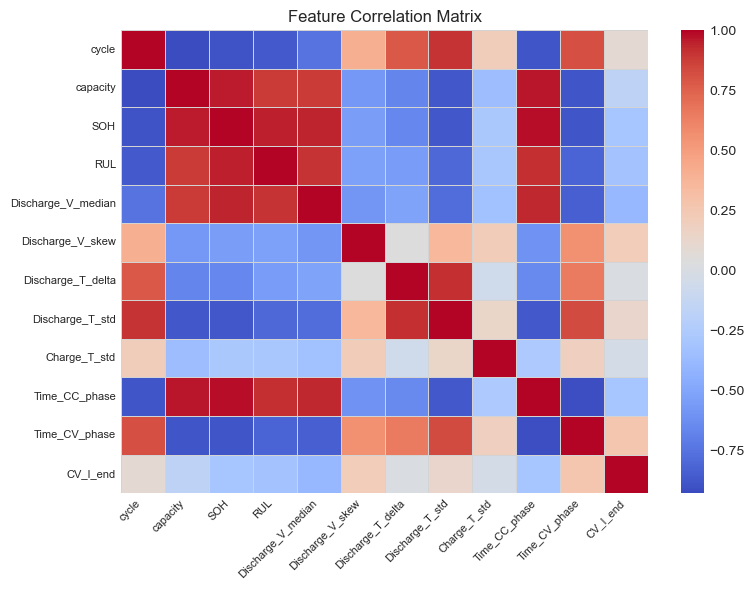

In [14]:
# Init object analyzer
analyzer = FeatureAnalyzer(combined_data=df_combined_copy)

# Plot heatmap
analyzer.plot_correlation_heatmap(figsize=(8, 6), annot=False)


Top 5 Positive/Negative:
Time_CC_phase         0.979121
capacity              0.958613
RUL                   0.948663
Discharge_V_median    0.943803
Charge_T_std         -0.279624
Name: SOH, dtype: float64
Discharge_V_skew    -0.551892
Discharge_T_delta   -0.659147
Discharge_T_std     -0.877038
Time_CV_phase       -0.888345
cycle               -0.894295
Name: SOH, dtype: float64

Plotting correlation with target: 'SOH'...


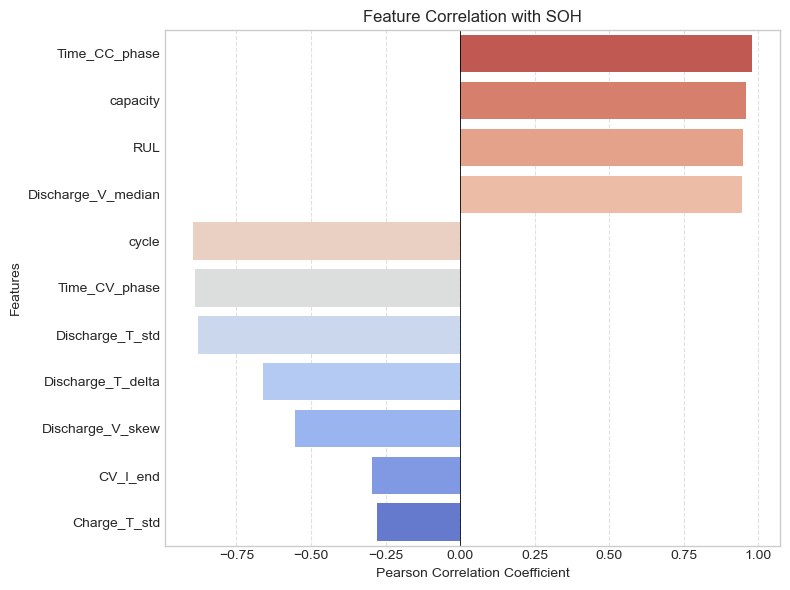

In [15]:
# Get correlation value with SOH and RUL
soh_correlation = analyzer.get_correlation_with_target('SOH')

print("Top 5 Positive/Negative:")
print(soh_correlation.drop('SOH', errors='ignore').head())
print(soh_correlation.drop('SOH', errors='ignore').tail())
analyzer.plot_correlation_with_target('SOH', sort_by_abs=True, figsize=(8,6))


In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import (
    LeaveOneGroupOut, GridSearchCV, GroupKFold, KFold, train_test_split
)
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C_kernel, WhiteKernel
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.base import clone
import matplotlib.pyplot as plt
import warnings
import time

warnings.filterwarnings('ignore')

# RANDOM FOREST

In [17]:
param_groups = [
    {
        'name': 'Group 1: Baseline (Default-ish)',
        'params': {
            'n_estimators': 100,
            'max_depth': None, # Cho phép cây phát triển đầy đủ
            'min_samples_split': 2,
            'min_samples_leaf': 1,
            'max_features': 'sqrt', # Mặc định cho hồi quy
            'random_state': 42,
            'n_jobs': -1
        }
    },
    {
        'name': 'Group 2: More Trees',
        'params': {
            'n_estimators': 300, # Tăng số cây
            'max_depth': None,
            'min_samples_split': 2,
            'min_samples_leaf': 1,
            'max_features': 'sqrt',
            'random_state': 42,
            'n_jobs': -1
        }
    },
    {
        'name': 'Group 3: Introduce Regularization (Mild)',
        'params': {
            'n_estimators': 300,
            'max_depth': 20, # Giới hạn độ sâu cây
            'min_samples_split': 5, # Yêu cầu nhiều mẫu hơn để tách
            'min_samples_leaf': 2, # Yêu cầu nhiều mẫu hơn ở nút lá
            'max_features': 'sqrt',
            'random_state': 42,
            'n_jobs': -1
        }
    },
    {
        'name': 'Group 4: More Trees & Stronger Regularization',
        'params': {
            'n_estimators': 500, # Tăng thêm số cây
            'max_depth': 15, # Giới hạn độ sâu chặt hơn một chút
            'min_samples_split': 10, # Yêu cầu nhiều mẫu hơn để tách
            'min_samples_leaf': 3, # Yêu cầu nhiều mẫu hơn ở nút lá
            'max_features': 0.8, # Thử sử dụng 80% đặc trưng
            'random_state': 42,
            'n_jobs': -1
        }
    },
    {
        'name': 'Group 5: High N_estimators & Fine-tuned',
        'params': {
            'n_estimators': 700, # Rất nhiều cây
            'max_depth': 25, # Cho phép cây sâu hơn một chút
            'min_samples_split': 5,
            'min_samples_leaf': 2,
            'max_features': 0.7, # Điều chỉnh số lượng đặc trưng
            'random_state': 42,
            'n_jobs': -1
        }
    }
]

# NOT USE LOBO, split data training/testing (3/1)

In [18]:
df_scaled = df_combined_copy.copy()
df_B0005 = df_scaled[df_scaled['battery_id'] == 'B0005'].copy()
df_B0006 = df_scaled[df_scaled['battery_id'] == 'B0006'].copy()
df_B0007 = df_scaled[df_scaled['battery_id'] == 'B0007'].copy()
df_B0018 = df_scaled[df_scaled['battery_id'] == 'B0018'].copy()

battery_dataframes = [df_B0005, df_B0006, df_B0007, df_B0018]

target_column = 'SOH'
group_column = 'battery_id'
cycle_plot_column = 'cycle'

feature_columns= ['Discharge_V_median', 'Discharge_T_std', 'Charge_T_std', 'Time_CC_phase']
battery_ids_for_plotting = ['B0005', 'B0006', 'B0007', 'B0018']


In [24]:
result_stored_rf = []

Tổng số mẫu cho pin B0005: 168 chu kỳ
Các đặc trưng đầu vào cho SOH: ['Discharge_V_median', 'Discharge_T_std', 'Charge_T_std', 'Time_CC_phase']
--- Bắt đầu quy trình đánh giá SOH cho pin B0005 (chia ngẫu nhiên 75:25) ---

======== Running with Group 1: Baseline (Default-ish) (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'random_state': 42, 'n_jobs': -1}
  Số lượng mẫu huấn luyện: 126
  Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.09 giây
  R-squared for B0005: 0.9928
  MAE for B0005: 0.6089
  RMSE for B0005: 0.8689


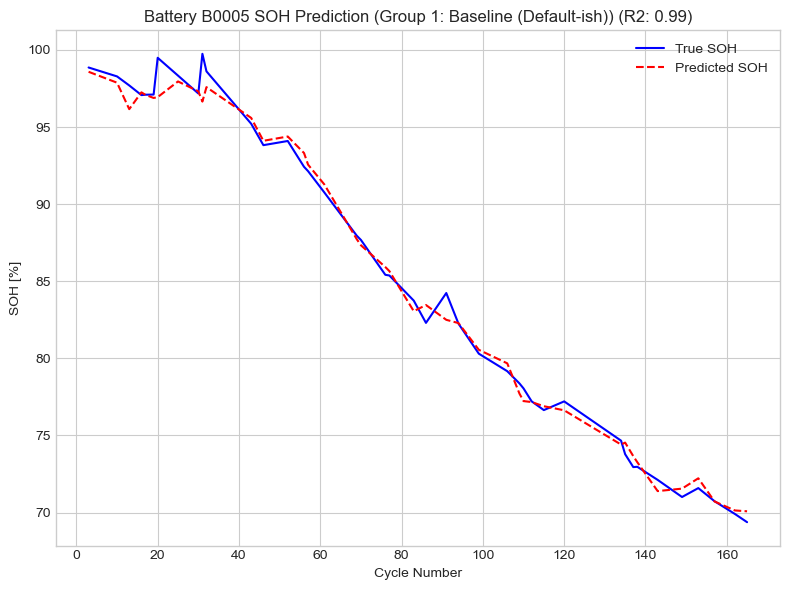


======== Running with Group 2: More Trees (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 300, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'random_state': 42, 'n_jobs': -1}
  Số lượng mẫu huấn luyện: 126
  Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.25 giây
  R-squared for B0005: 0.9931
  MAE for B0005: 0.6027
  RMSE for B0005: 0.8512


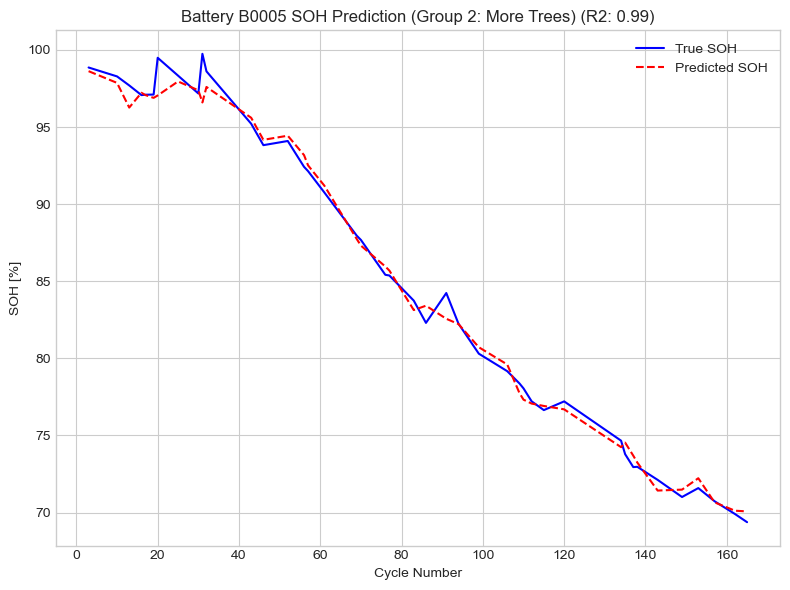


======== Running with Group 3: Introduce Regularization (Mild) (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 300, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'random_state': 42, 'n_jobs': -1}
  Số lượng mẫu huấn luyện: 126
  Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.25 giây
  R-squared for B0005: 0.9931
  MAE for B0005: 0.6304
  RMSE for B0005: 0.8527


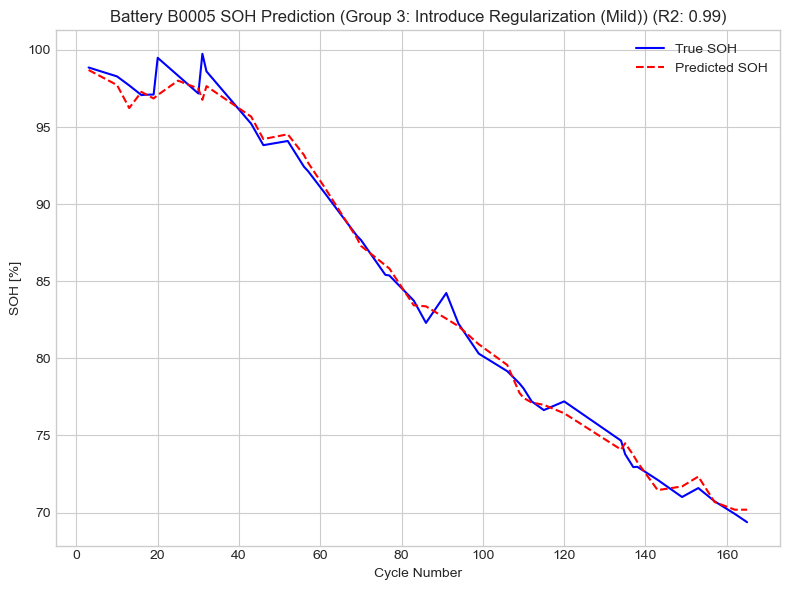


======== Running with Group 4: More Trees & Stronger Regularization (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 500, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 0.8, 'random_state': 42, 'n_jobs': -1}
  Số lượng mẫu huấn luyện: 126
  Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.40 giây
  R-squared for B0005: 0.9917
  MAE for B0005: 0.6773
  RMSE for B0005: 0.9321


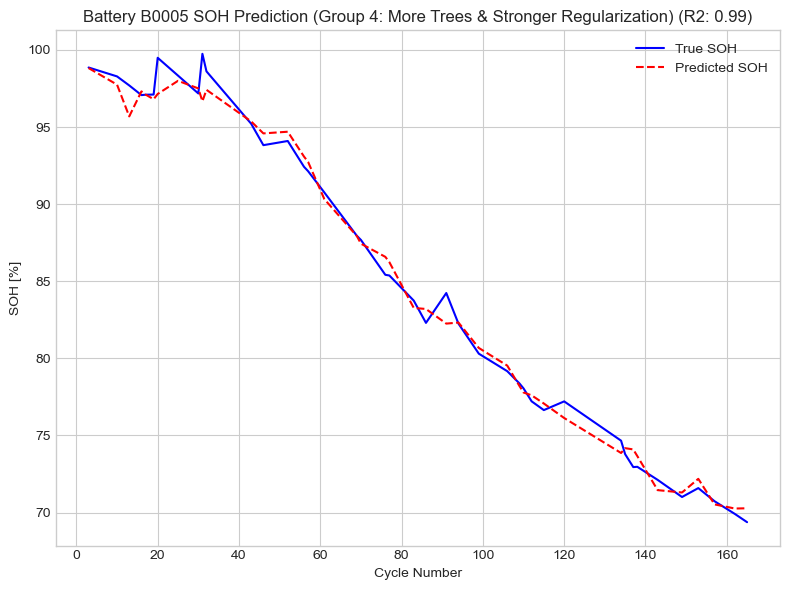


======== Running with Group 5: High N_estimators & Fine-tuned (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 700, 'max_depth': 25, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.7, 'random_state': 42, 'n_jobs': -1}
  Số lượng mẫu huấn luyện: 126
  Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.55 giây
  R-squared for B0005: 0.9930
  MAE for B0005: 0.6327
  RMSE for B0005: 0.8556


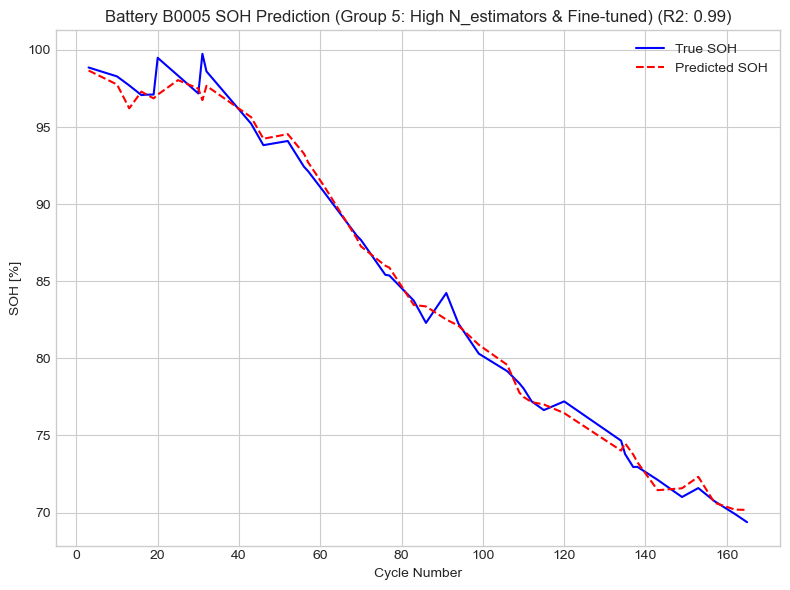


--- Đánh giá trên tất cả các nhóm tham số cho pin B0005 hoàn tất ---


In [25]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Trích xuất X và Y cho pin B0005
X_B0005 = df_B0005[feature_columns]
y_B0005 = df_B0005[target_column]
cycles_B0005 = df_B0005[cycle_plot_column] # Để vẽ đồ thị
metrics_validate_B0005 = []

print(f"Tổng số mẫu cho pin B0005: {len(df_B0005)} chu kỳ")
print(f"Các đặc trưng đầu vào cho SOH: {feature_columns}")

print("--- Bắt đầu quy trình đánh giá SOH cho pin B0005 (chia ngẫu nhiên 75:25) ---")

# Lặp qua từng nhóm tham số Random Forest
for group_index, param_group in enumerate(param_groups):
    group_name = param_group['name']
    params = param_group['params']

    print(f"\n======== Running with {group_name} (RF Hyperparameters for SOH) ========")
    print(f"Parameters: {params}")

    # Khởi tạo mô hình Random Forest với các tham số của nhóm hiện tại
    rf_model = RandomForestRegressor(**params)

    # Chia dữ liệu của pin B0005 75% huấn luyện : 25% kiểm thử ngẫu nhiên
    # random_state=42 để đảm bảo kết quả lặp lại
    X_train, X_test, y_train, y_test = train_test_split(
        X_B0005, y_B0005, test_size=0.25, random_state=42
    )

    print(f"  Số lượng mẫu huấn luyện: {len(X_train)}")
    print(f"  Số lượng mẫu kiểm thử: {len(X_test)}")

    # Đo thời gian huấn luyện mô hình
    start_time = time.time()

    # Huấn luyện mô hình Random Forest-
    rf_model.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"  Thời gian huấn luyện: {training_time:.2f} giây")
    y_pred = rf_model.predict(X_test)

    # Đánh giá hiệu suất
    battery_r2 = r2_score(y_test, y_pred)
    battery_mae = mean_absolute_error(y_test, y_pred)
    battery_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    metrics_validate_B0005.append({
        'group_name': group_name,
        'r2': battery_r2,
        'mae': battery_mae,
        'rmse': battery_rmse
    })
    print(f"  R-squared for B0005: {battery_r2:.4f}")
    print(f"  MAE for B0005: {battery_mae:.4f}")
    print(f"  RMSE for B0005: {battery_rmse:.4f}")

    # --- VẼ ĐỒ THỊ CHO PIN B0005 ---
    fig, ax = plt.subplots(figsize=(8, 6)) # Một figure cho mỗi nhóm tham số
    
    # Lấy chu kỳ từ original df_B0005 bằng cách dùng index của y_test
    # Sau đó sắp xếp để đường cong mượt
    test_cycle_data_for_plot = cycles_B0005.loc[y_test.index].sort_values()

    # Tạo DataFrame cho đồ thị
    plot_df = pd.DataFrame({
        'Cycle': test_cycle_data_for_plot,
        'True SOH': y_test.loc[test_cycle_data_for_plot.index], # Đảm bảo lấy đúng giá trị theo index đã sắp xếp
        'Predicted SOH': y_pred[np.argsort(y_test.index.values)] # Sắp xếp y_pred theo thứ tự index của y_test
    }).sort_values(by='Cycle')
    if group_index == 0:
        result_stored_rf.append(plot_df)
    sns.lineplot(x='Cycle', y='True SOH', data=plot_df, label='True SOH', color='blue', ax=ax)
    sns.lineplot(x='Cycle', y='Predicted SOH', data=plot_df, label='Predicted SOH', color='red', linestyle='--')
    
    ax.set_title(f'Battery B0005 SOH Prediction ({group_name}) (R2: {battery_r2:.2f})')
    ax.set_xlabel('Cycle Number')
    ax.set_ylabel('SOH [%]')
    ax.legend()
    ax.grid(True)
    
    plt.tight_layout()
    plt.show() 
    plt.close(fig) # Đóng figure để giải phóng bộ nhớ

print("\n--- Đánh giá trên tất cả các nhóm tham số cho pin B0005 hoàn tất ---")


Tổng số mẫu cho pin B0005: 168 chu kỳ
Các đặc trưng đầu vào cho SOH: ['Discharge_V_median', 'Discharge_T_std', 'Charge_T_std', 'Time_CC_phase']
--- Bắt đầu quy trình đánh giá SOH cho pin B0005 (chia ngẫu nhiên 75:25) ---

======== Running with Group 1: Baseline (Default-ish) (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'random_state': 42, 'n_jobs': -1}
  Số lượng mẫu huấn luyện: 126
  Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.10 giây
  R-squared for B0005: 0.9892
  MAE for B0005: 0.9208
  RMSE for B0005: 1.2917


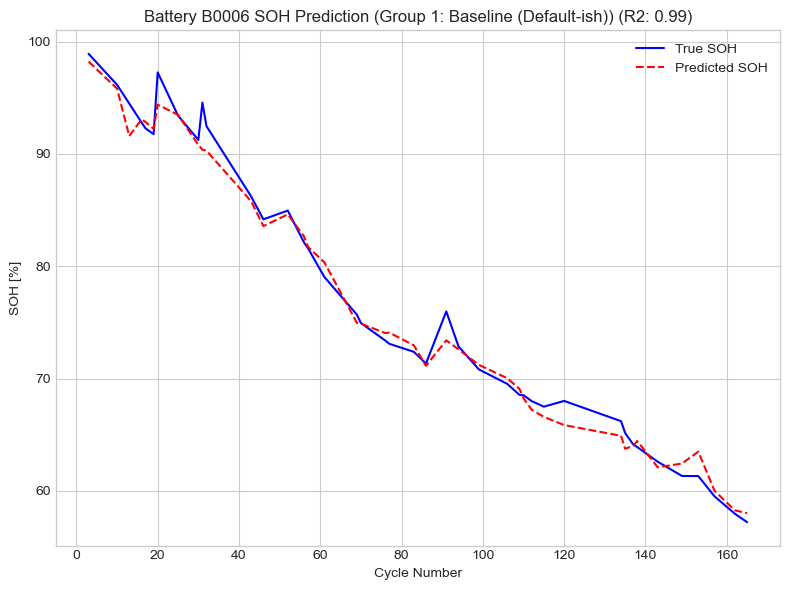


======== Running with Group 2: More Trees (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 300, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'random_state': 42, 'n_jobs': -1}
  Số lượng mẫu huấn luyện: 126
  Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.25 giây
  R-squared for B0005: 0.9891
  MAE for B0005: 0.9294
  RMSE for B0005: 1.2962


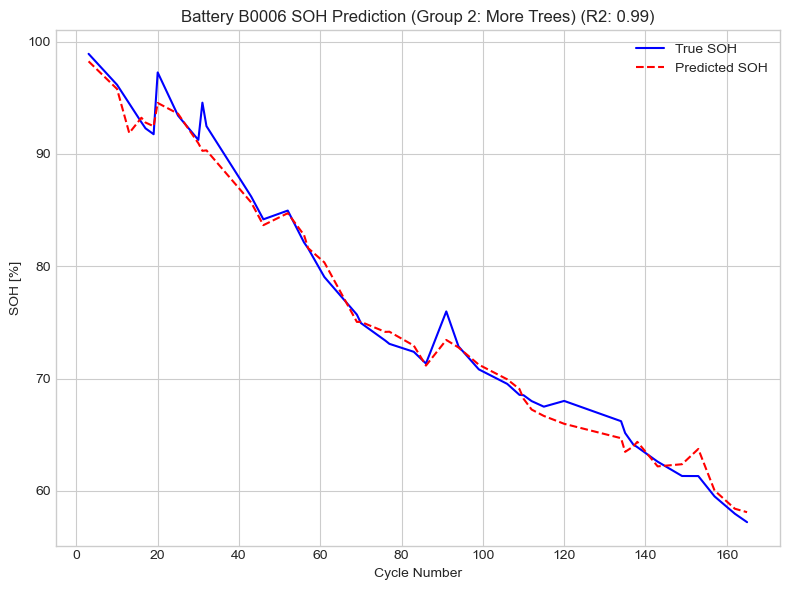


======== Running with Group 3: Introduce Regularization (Mild) (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 300, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'random_state': 42, 'n_jobs': -1}
  Số lượng mẫu huấn luyện: 126
  Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.25 giây
  R-squared for B0005: 0.9874
  MAE for B0005: 1.0226
  RMSE for B0005: 1.3945


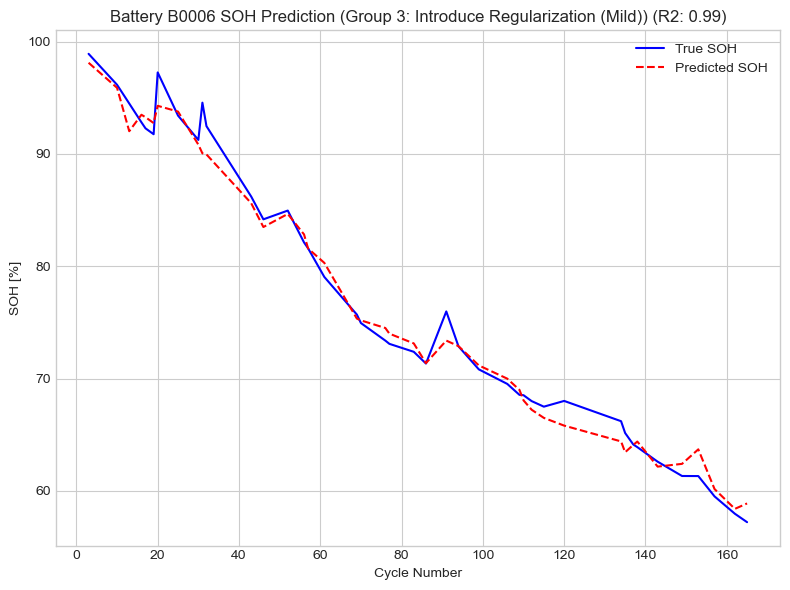


======== Running with Group 4: More Trees & Stronger Regularization (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 500, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 0.8, 'random_state': 42, 'n_jobs': -1}
  Số lượng mẫu huấn luyện: 126
  Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.37 giây
  R-squared for B0005: 0.9864
  MAE for B0005: 1.0643
  RMSE for B0005: 1.4505


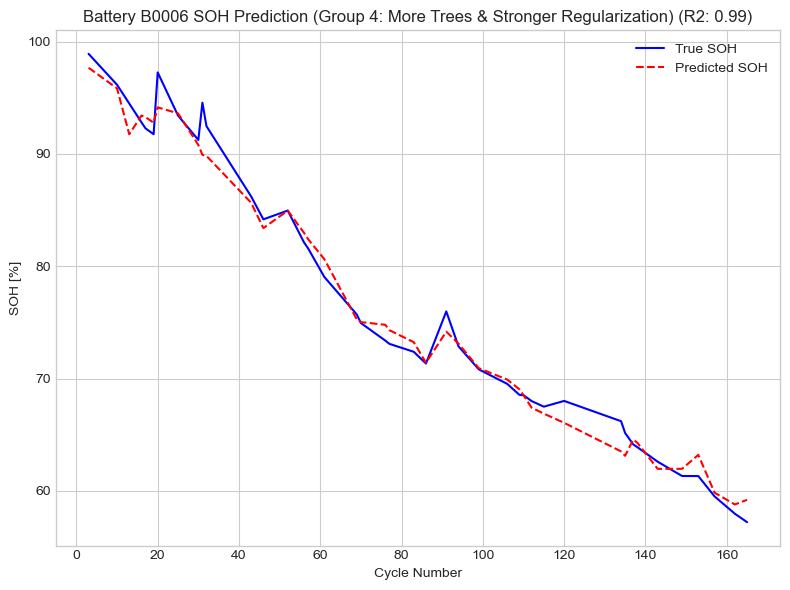


======== Running with Group 5: High N_estimators & Fine-tuned (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 700, 'max_depth': 25, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.7, 'random_state': 42, 'n_jobs': -1}
  Số lượng mẫu huấn luyện: 126
  Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.54 giây
  R-squared for B0005: 0.9877
  MAE for B0005: 1.0118
  RMSE for B0005: 1.3780


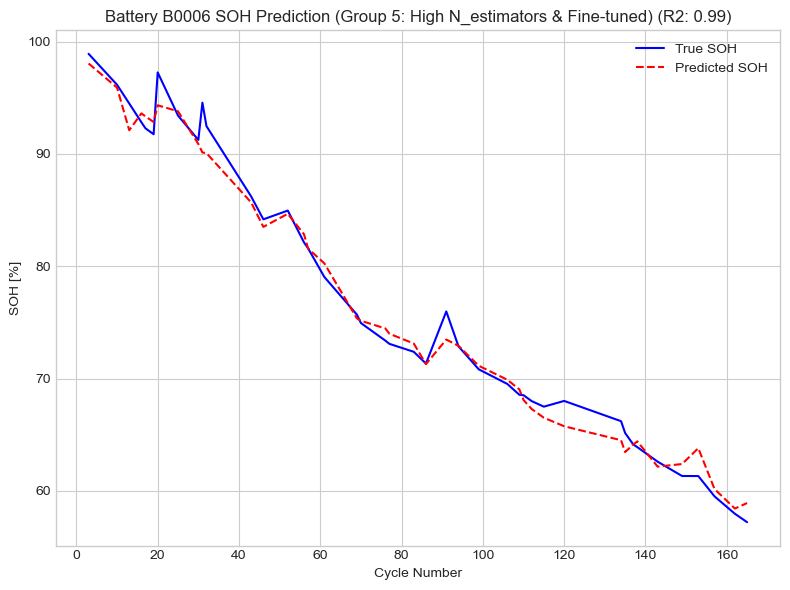

In [26]:
# Trích xuất X và Y cho pin B0005
X_B0006 = df_B0006[feature_columns]
y_B0006 = df_B0006[target_column]
cycles_B0006 = df_B0006[cycle_plot_column] # Để vẽ đồ thị


print(f"Tổng số mẫu cho pin B0005: {len(df_B0006)} chu kỳ")
print(f"Các đặc trưng đầu vào cho SOH: {feature_columns}")

print("--- Bắt đầu quy trình đánh giá SOH cho pin B0005 (chia ngẫu nhiên 75:25) ---")
metrics_validate_B0006 = []
# Lặp qua từng nhóm tham số Random Forest
for group_index, param_group in enumerate(param_groups):
    group_name = param_group['name']
    params = param_group['params']

    print(f"\n======== Running with {group_name} (RF Hyperparameters for SOH) ========")
    print(f"Parameters: {params}")

    # Khởi tạo mô hình Random Forest với các tham số của nhóm hiện tại
    rf_model = RandomForestRegressor(**params)

    # Chia dữ liệu của pin B0005 75% huấn luyện : 25% kiểm thử ngẫu nhiên
    # random_state=42 để đảm bảo kết quả lặp lại
    X_train, X_test, y_train, y_test = train_test_split(
        X_B0006, y_B0006, test_size=0.25, random_state=42
    )

    print(f"  Số lượng mẫu huấn luyện: {len(X_train)}")
    print(f"  Số lượng mẫu kiểm thử: {len(X_test)}")

    start_time = time.time()
    # Huấn luyện mô hình Random Forest-
    rf_model.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"  Thời gian huấn luyện: {training_time:.2f} giây")
    y_pred = rf_model.predict(X_test)

    # Đánh giá hiệu suất
    battery_r2 = r2_score(y_test, y_pred)
    battery_mae = mean_absolute_error(y_test, y_pred)
    battery_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"  R-squared for B0005: {battery_r2:.4f}")
    print(f"  MAE for B0005: {battery_mae:.4f}")
    print(f"  RMSE for B0005: {battery_rmse:.4f}")
    metrics_validate_B0006.append({
        'group_name': group_name,
        'r2': battery_r2,
        'mae': battery_mae,
        'rmse': battery_rmse
    })
    # --- VẼ ĐỒ THỊ CHO PIN B0005 ---
    fig, ax = plt.subplots(figsize=(8, 6)) # Một figure cho mỗi nhóm tham số
    
    # Lấy chu kỳ từ original df_B0005 bằng cách dùng index của y_test
    # Sau đó sắp xếp để đường cong mượt
    test_cycle_data_for_plot = cycles_B0006.loc[y_test.index].sort_values()

    # Tạo DataFrame cho đồ thị
    plot_df = pd.DataFrame({
        'Cycle': test_cycle_data_for_plot,
        'True SOH': y_test.loc[test_cycle_data_for_plot.index], # Đảm bảo lấy đúng giá trị theo index đã sắp xếp
        'Predicted SOH': y_pred[np.argsort(y_test.index.values)] # Sắp xếp y_pred theo thứ tự index của y_test
    }).sort_values(by='Cycle')
    if group_index == 0:
        result_stored_rf.append(plot_df)
    sns.lineplot(x='Cycle', y='True SOH', data=plot_df, label='True SOH', color='blue', ax=ax)
    sns.lineplot(x='Cycle', y='Predicted SOH', data=plot_df, label='Predicted SOH', color='red', linestyle='--')
    
    ax.set_title(f'Battery B0006 SOH Prediction ({group_name}) (R2: {battery_r2:.2f})')
    ax.set_xlabel('Cycle Number')
    ax.set_ylabel('SOH [%]')
    ax.legend()
    ax.grid(True)
    
    plt.tight_layout()
    plt.show() 
    plt.close(fig) # Đóng figure để giải phóng bộ nhớ


Tổng số mẫu cho pin B0007: 168 chu kỳ
Các đặc trưng đầu vào cho SOH: ['Discharge_V_median', 'Discharge_T_std', 'Charge_T_std', 'Time_CC_phase']
--- Bắt đầu quy trình đánh giá SOH cho pin B0007 (chia ngẫu nhiên 75:25) ---

======== Running with Group 1: Baseline (Default-ish) (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'random_state': 42, 'n_jobs': -1}
  Số lượng mẫu huấn luyện: 126
  Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.10 giây
  R-squared for B0007: 0.9885
  MAE for B0007: 0.5300
  RMSE for B0007: 0.9147


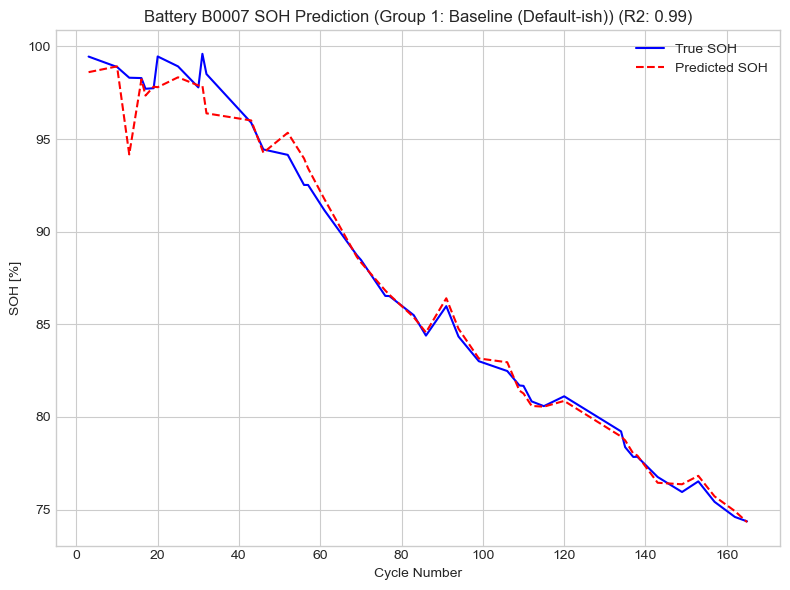


======== Running with Group 2: More Trees (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 300, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'random_state': 42, 'n_jobs': -1}
  Số lượng mẫu huấn luyện: 126
  Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.31 giây
  R-squared for B0007: 0.9877
  MAE for B0007: 0.5227
  RMSE for B0007: 0.9447


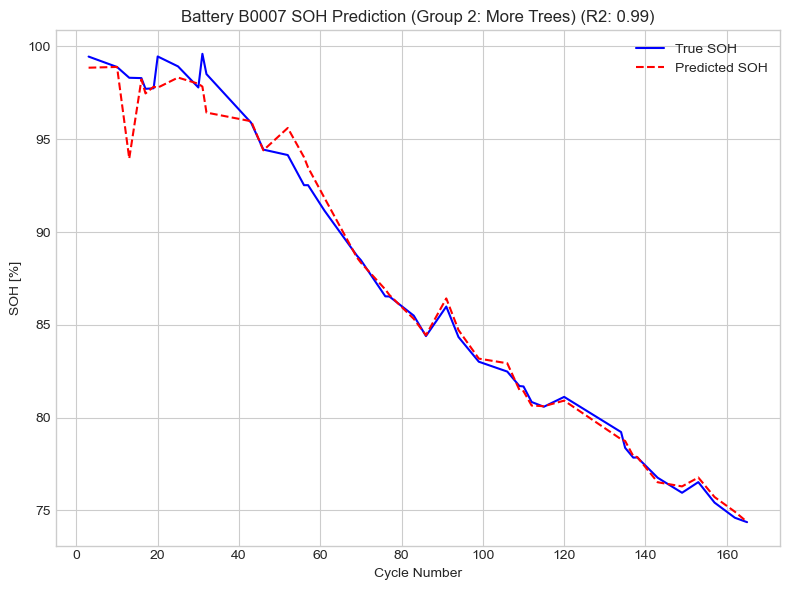


======== Running with Group 3: Introduce Regularization (Mild) (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 300, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'random_state': 42, 'n_jobs': -1}
  Số lượng mẫu huấn luyện: 126
  Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.24 giây
  R-squared for B0007: 0.9874
  MAE for B0007: 0.5399
  RMSE for B0007: 0.9573


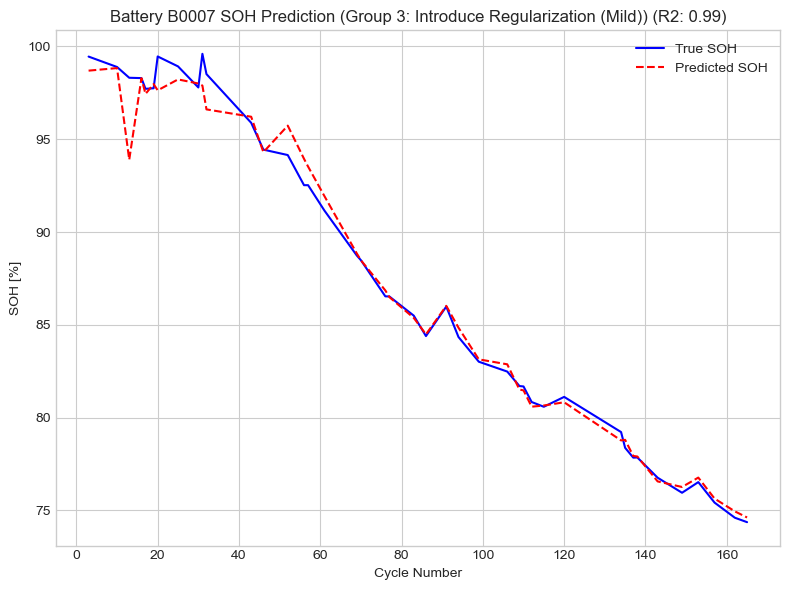


======== Running with Group 4: More Trees & Stronger Regularization (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 500, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 0.8, 'random_state': 42, 'n_jobs': -1}
  Số lượng mẫu huấn luyện: 126
  Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.38 giây
  R-squared for B0007: 0.9834
  MAE for B0007: 0.5776
  RMSE for B0007: 1.1000


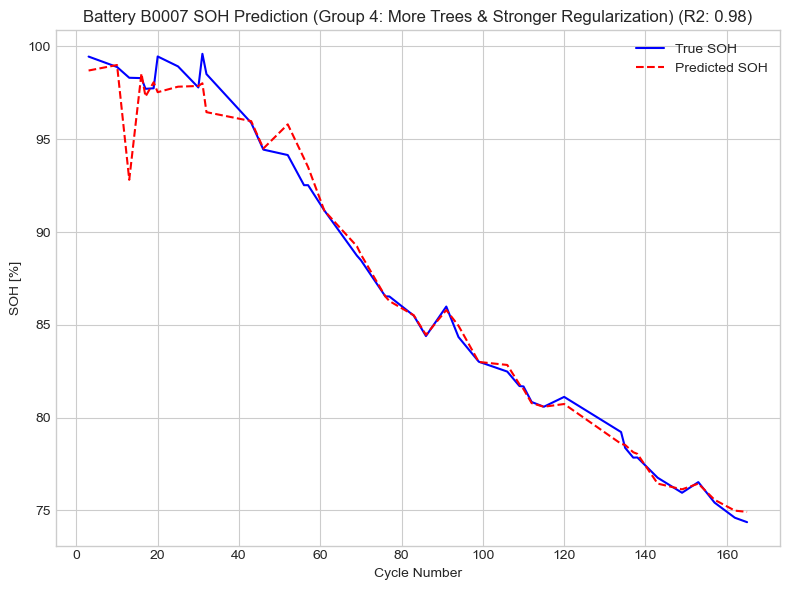


======== Running with Group 5: High N_estimators & Fine-tuned (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 700, 'max_depth': 25, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.7, 'random_state': 42, 'n_jobs': -1}
  Số lượng mẫu huấn luyện: 126
  Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.53 giây
  R-squared for B0007: 0.9872
  MAE for B0007: 0.5425
  RMSE for B0007: 0.9652


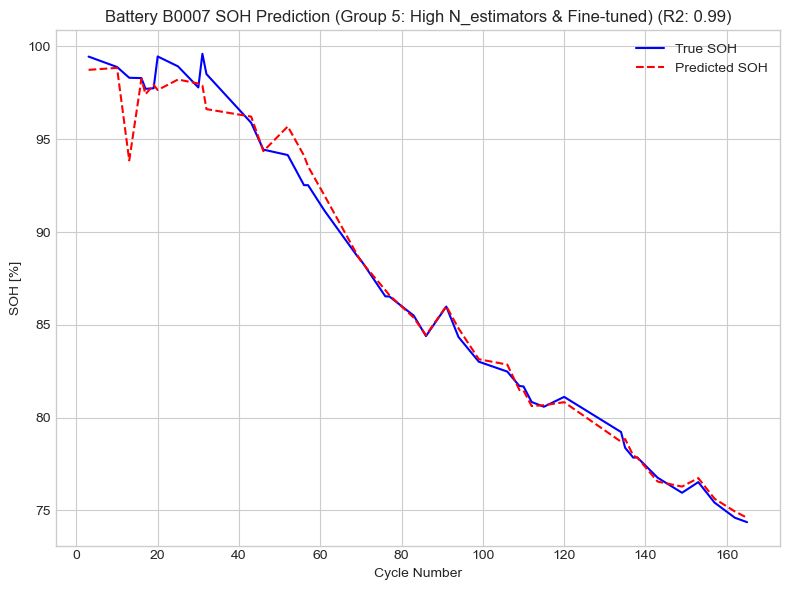

In [27]:
# Trích xuất X và Y cho pin B0005
X_B0007 = df_B0007[feature_columns]
y_B0007 = df_B0007[target_column]
cycles_B0007 = df_B0007[cycle_plot_column] # Để vẽ đồ thị


print(f"Tổng số mẫu cho pin B0007: {len(df_B0007)} chu kỳ")
print(f"Các đặc trưng đầu vào cho SOH: {feature_columns}")

print("--- Bắt đầu quy trình đánh giá SOH cho pin B0007 (chia ngẫu nhiên 75:25) ---")
metrics_validate_B0007 = []
# Lặp qua từng nhóm tham số Random Forest
for group_index, param_group in enumerate(param_groups):
    group_name = param_group['name']
    params = param_group['params']

    print(f"\n======== Running with {group_name} (RF Hyperparameters for SOH) ========")
    print(f"Parameters: {params}")

    # Khởi tạo mô hình Random Forest với các tham số của nhóm hiện tại
    rf_model = RandomForestRegressor(**params)

    # Chia dữ liệu của pin B0005 75% huấn luyện : 25% kiểm thử ngẫu nhiên
    # random_state=42 để đảm bảo kết quả lặp lại
    X_train, X_test, y_train, y_test = train_test_split(
        X_B0007, y_B0007, test_size=0.25, random_state=42
    )

    print(f"  Số lượng mẫu huấn luyện: {len(X_train)}")
    print(f"  Số lượng mẫu kiểm thử: {len(X_test)}")

    start_time = time.time()
    # Huấn luyện mô hình Random Forest-
    rf_model.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"  Thời gian huấn luyện: {training_time:.2f} giây")
    y_pred = rf_model.predict(X_test)

    # Đánh giá hiệu suất
    battery_r2 = r2_score(y_test, y_pred)
    battery_mae = mean_absolute_error(y_test, y_pred)
    battery_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"  R-squared for B0007: {battery_r2:.4f}")
    print(f"  MAE for B0007: {battery_mae:.4f}")
    print(f"  RMSE for B0007: {battery_rmse:.4f}")
    metrics_validate_B0007.append({
        'group_name': group_name,
        'r2': battery_r2,
        'mae': battery_mae,
        'rmse': battery_rmse
    })
    # --- VẼ ĐỒ THỊ CHO PIN B0005 ---
    fig, ax = plt.subplots(figsize=(8, 6)) # Một figure cho mỗi nhóm tham số
    
    # Lấy chu kỳ từ original df_B0005 bằng cách dùng index của y_test
    # Sau đó sắp xếp để đường cong mượt
    test_cycle_data_for_plot = cycles_B0007.loc[y_test.index].sort_values()

    # Tạo DataFrame cho đồ thị
    plot_df = pd.DataFrame({
        'Cycle': test_cycle_data_for_plot,
        'True SOH': y_test.loc[test_cycle_data_for_plot.index], # Đảm bảo lấy đúng giá trị theo index đã sắp xếp
        'Predicted SOH': y_pred[np.argsort(y_test.index.values)] # Sắp xếp y_pred theo thứ tự index của y_test
    }).sort_values(by='Cycle')
    if group_index == 0:
        result_stored_rf.append(plot_df)
    sns.lineplot(x='Cycle', y='True SOH', data=plot_df, label='True SOH', color='blue', ax=ax)
    sns.lineplot(x='Cycle', y='Predicted SOH', data=plot_df, label='Predicted SOH', color='red', linestyle='--')
    
    ax.set_title(f'Battery B0007 SOH Prediction ({group_name}) (R2: {battery_r2:.2f})')
    ax.set_xlabel('Cycle Number')
    ax.set_ylabel('SOH [%]')
    ax.legend()
    ax.grid(True)
    
    plt.tight_layout()
    plt.show() 
    plt.close(fig) # Đóng figure để giải phóng bộ nhớ


Tổng số mẫu cho pin B0018: 132 chu kỳ
Các đặc trưng đầu vào cho SOH: ['Discharge_V_median', 'Discharge_T_std', 'Charge_T_std', 'Time_CC_phase']
--- Bắt đầu quy trình đánh giá SOH cho pin B0018 (chia ngẫu nhiên 75:25) ---

======== Running with Group 1: Baseline (Default-ish) (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'random_state': 42, 'n_jobs': -1}
  Số lượng mẫu huấn luyện: 99
  Số lượng mẫu kiểm thử: 33
  Thời gian huấn luyện: 0.10 giây
[89.07326635 78.19145038 93.98681215 89.75468507 79.95563416 73.31953379
 86.6555307  75.81933777 82.557108   93.12286176 85.81067325 92.79599199
 92.45527075 97.80087628 75.09764133 73.53597808 87.09024561 77.63769435
 88.67261913 85.00624529 94.20429887 98.04331499 86.64894766 97.72450952
 77.26044372 82.39646654 74.10691264 74.79342205 74.53841169 95.42432195
 97.07740114 73.21933328 81.16727221]
56      88.432930
83      77.0158

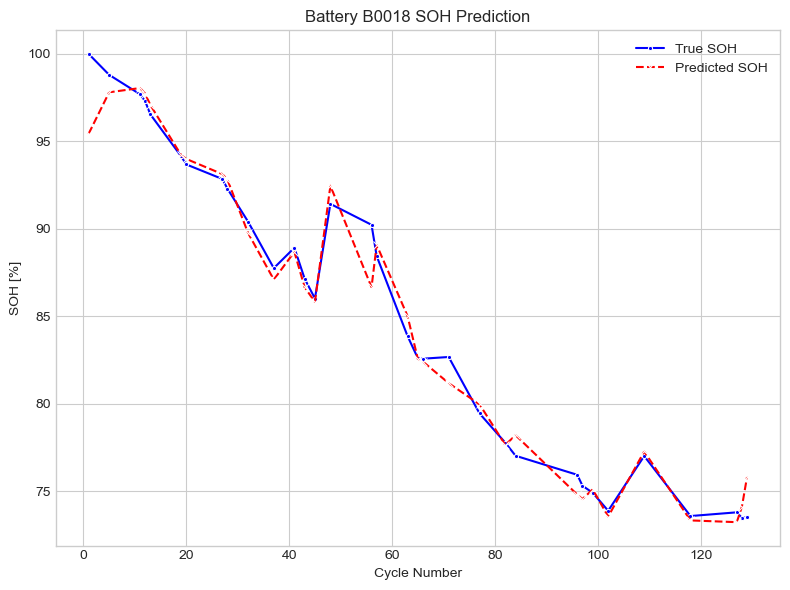


======== Running with Group 2: More Trees (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 300, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'random_state': 42, 'n_jobs': -1}
  Số lượng mẫu huấn luyện: 99
  Số lượng mẫu kiểm thử: 33
  Thời gian huấn luyện: 0.24 giây
[89.10955283 78.21816112 93.87550237 89.72963442 79.86959427 73.32366968
 86.65158578 75.94508008 82.57208137 93.21339247 85.84218427 92.9222178
 92.1605931  97.81409545 75.07911955 73.54046826 87.13044023 77.61442115
 88.65107179 84.84877579 94.16636488 98.0679785  86.58049939 97.76829334
 77.30379582 82.34122227 74.14016831 74.88939728 74.57222236 95.46584608
 97.09237151 73.17473736 81.12771469]
56      88.432930
83      77.015854
19      93.674420
31      90.402856
76      79.434188
117     73.569464
55      90.223247
128     73.498749
64      82.596095
26      92.842433
44      86.008624
27      92.282594
47      91.418837
4       98.797614
98      74.8981

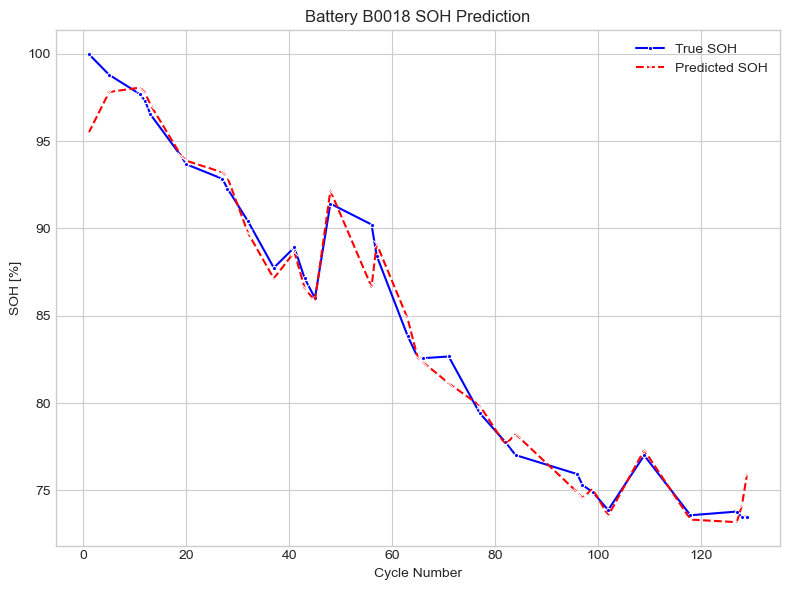


======== Running with Group 3: Introduce Regularization (Mild) (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 300, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'random_state': 42, 'n_jobs': -1}
  Số lượng mẫu huấn luyện: 99
  Số lượng mẫu kiểm thử: 33
  Thời gian huấn luyện: 0.24 giây
[89.25682293 78.21006894 93.77874699 89.84041264 79.9848786  73.380929
 86.56137201 75.97762268 82.51823098 93.260613   85.82956515 93.14179141
 92.58584557 97.84819093 75.16176616 73.64173938 87.06245125 77.6012404
 88.64498939 84.81263714 94.26094667 98.02727063 86.45896863 97.8774989
 77.36126877 82.18344206 74.15763164 74.95312689 74.64874458 95.34708422
 97.21632186 73.18001256 81.07088382]
56      88.432930
83      77.015854
19      93.674420
31      90.402856
76      79.434188
117     73.569464
55      90.223247
128     73.498749
64      82.596095
26      92.842433
44      86.008624
27      92.282594
47      91.418837
4       98.797614

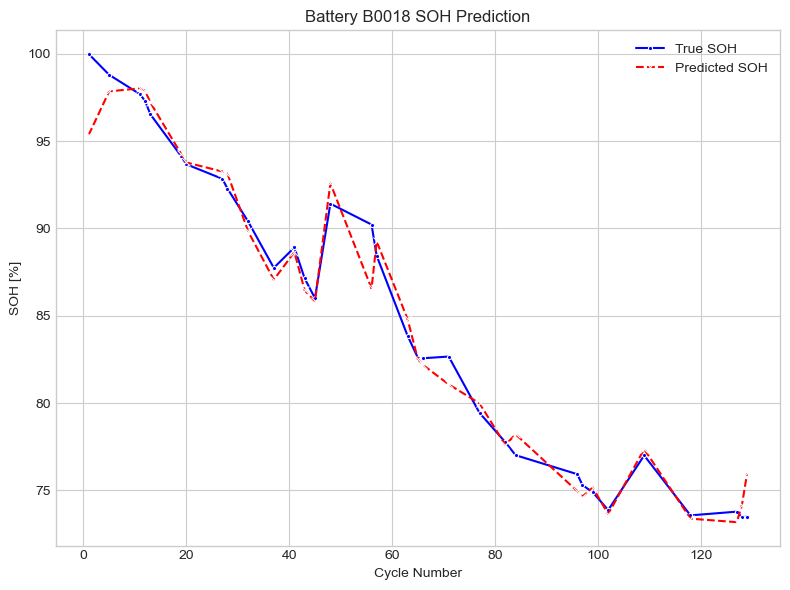


======== Running with Group 4: More Trees & Stronger Regularization (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 500, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 0.8, 'random_state': 42, 'n_jobs': -1}
  Số lượng mẫu huấn luyện: 99
  Số lượng mẫu kiểm thử: 33
  Thời gian huấn luyện: 0.41 giây
[89.25184632 78.18552753 93.76111815 89.97275437 80.09947893 73.32906605
 86.726778   76.16307073 82.10594936 93.7133023  85.74671728 93.48594108
 91.81087919 97.51253551 75.33377805 73.74998607 86.87178827 77.65170582
 88.82064737 84.29366287 94.43966381 97.60228309 86.55048593 97.59460941
 77.25327488 81.56361473 74.05229631 74.97528344 74.76660161 95.86809555
 97.45455517 73.32186851 81.10641035]
56      88.432930
83      77.015854
19      93.674420
31      90.402856
76      79.434188
117     73.569464
55      90.223247
128     73.498749
64      82.596095
26      92.842433
44      86.008624
27      92.282594
47      91.418837
4       98

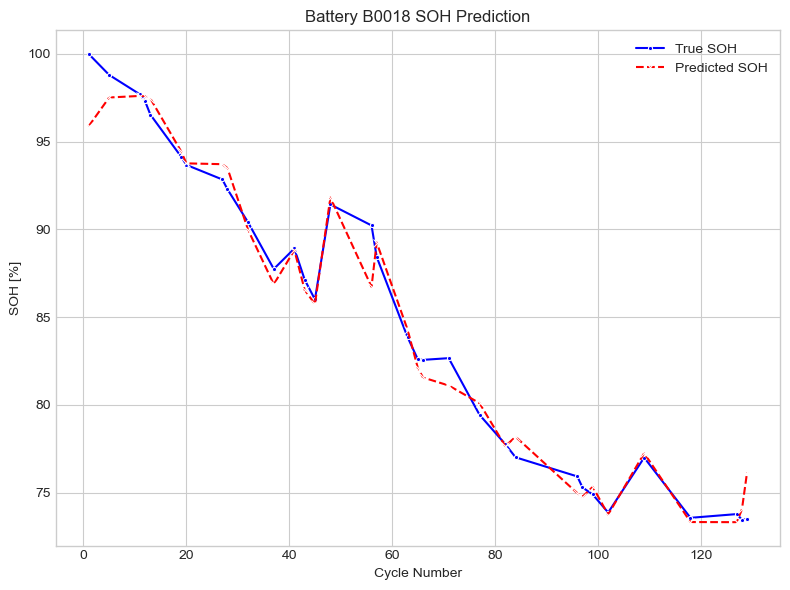


======== Running with Group 5: High N_estimators & Fine-tuned (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 700, 'max_depth': 25, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.7, 'random_state': 42, 'n_jobs': -1}
  Số lượng mẫu huấn luyện: 99
  Số lượng mẫu kiểm thử: 33
  Thời gian huấn luyện: 0.55 giây
[89.28738155 78.19692763 93.68123882 89.78547496 80.04543933 73.37359969
 86.59410832 76.04036973 82.57549475 93.26987145 85.70187249 93.02320736
 92.47257624 97.86178183 75.16746535 73.64558464 87.04917146 77.57311005
 88.62121863 84.90403282 94.19903927 97.99491397 86.43652272 97.86482919
 77.36313686 82.12530359 74.10218333 74.97070505 74.64945471 95.48347114
 97.19293668 73.18281141 81.11023685]
56      88.432930
83      77.015854
19      93.674420
31      90.402856
76      79.434188
117     73.569464
55      90.223247
128     73.498749
64      82.596095
26      92.842433
44      86.008624
27      92.282594
47      91.418837
4       98.797614

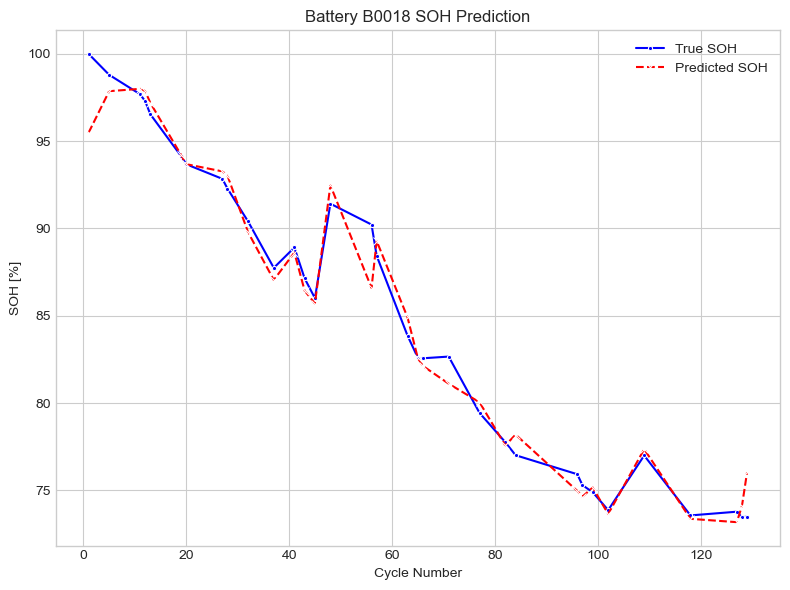

In [28]:
# Trích xuất X và Y cho pin B0005
X_B0018 = df_B0018[feature_columns]
y_B0018 = df_B0018[target_column]
cycles_B0018 = df_B0018[cycle_plot_column] # Để vẽ đồ thị

metrics_validate_B0018 = []
print(f"Tổng số mẫu cho pin B0018: {len(df_B0018)} chu kỳ")
print(f"Các đặc trưng đầu vào cho SOH: {feature_columns}")

print("--- Bắt đầu quy trình đánh giá SOH cho pin B0018 (chia ngẫu nhiên 75:25) ---")

# Lặp qua từng nhóm tham số Random Forest
for group_index, param_group in enumerate(param_groups):
    group_name = param_group['name']
    params = param_group['params']

    print(f"\n======== Running with {group_name} (RF Hyperparameters for SOH) ========")
    print(f"Parameters: {params}")

    # Khởi tạo mô hình Random Forest với các tham số của nhóm hiện tại
    rf_model = RandomForestRegressor(**params)

    # Chia dữ liệu của pin B0005 75% huấn luyện : 25% kiểm thử ngẫu nhiên
    # random_state=42 để đảm bảo kết quả lặp lại
    X_train, X_test, y_train, y_test = train_test_split(
        X_B0018, y_B0018, test_size=0.25, random_state=42
    )

    print(f"  Số lượng mẫu huấn luyện: {len(X_train)}")
    print(f"  Số lượng mẫu kiểm thử: {len(X_test)}")

    start_time = time.time()
    # Huấn luyện mô hình Random Forest-
    rf_model.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"  Thời gian huấn luyện: {training_time:.2f} giây")
    y_pred = rf_model.predict(X_test)
    print(y_pred)
    print(y_test)
    # Đánh giá hiệu suất
    battery_r2 = r2_score(y_test, y_pred)
    battery_mae = mean_absolute_error(y_test, y_pred)
    battery_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"  R-squared for B0018: {battery_r2:.4f}")
    print(f"  MAE for B0018: {battery_mae:.4f}")
    print(f"  RMSE for B0018: {battery_rmse:.4f}")
    metrics_validate_B0018.append({
        'group_name': group_name,
        'r2': battery_r2,
        'mae': battery_mae,
        'rmse': battery_rmse
    })
    # --- VẼ ĐỒ THỊ CHO PIN B0005 ---
    fig, ax = plt.subplots(figsize=(8, 6)) # Một figure cho mỗi nhóm tham số
    
    # Lấy chu kỳ từ original df_B0005 bằng cách dùng index của y_test
    # Sau đó sắp xếp để đường cong mượt
    test_cycle_data_for_plot = cycles_B0018.loc[y_test.index].sort_values()

    # Tạo DataFrame cho đồ thị
    plot_df = pd.DataFrame({
        'Cycle': test_cycle_data_for_plot,
        'True SOH': y_test.loc[test_cycle_data_for_plot.index], # Đảm bảo lấy đúng giá trị theo index đã sắp xếp
        'Predicted SOH': y_pred[np.argsort(y_test.index.values)] # Sắp xếp y_pred theo thứ tự index của y_test
    }).sort_values(by='Cycle')
    if group_index == 0:
        result_stored_rf.append(plot_df)
    sns.lineplot(x='Cycle', y='True SOH', data=plot_df, label='True SOH', color='blue', ax=ax, marker='.', markersize=6)
    sns.lineplot(x='Cycle', y='Predicted SOH', data=plot_df, label='Predicted SOH', color='red', linestyle='--', marker='x', markersize=6)
    
    ax.set_title(f'Battery B0018 SOH Prediction')
    ax.set_xlabel('Cycle Number')
    ax.set_ylabel('SOH [%]')
    ax.legend()
    ax.grid(True)
    
    plt.tight_layout()
    plt.show() 
    plt.close(fig) # Đóng figure để giải phóng bộ nhớ


In [23]:
for i in range(5):
    print(f'Mean R-square group {i + 1}: ', (metrics_validate_B0018[i]['r2'] + metrics_validate_B0005[i]['r2'] + metrics_validate_B0006[i]['r2'] + metrics_validate_B0007[i]['r2']) / 4)
    print(f'Mean MAE group {i + 1}: ', (metrics_validate_B0005[i]['mae'] + metrics_validate_B0006[i]['mae'] + metrics_validate_B0007[i]['mae'] + metrics_validate_B0018[i]['mae']) / 4)
    print(f'Mean RMSE group {i + 1}: ', (metrics_validate_B0005[i]['rmse'] + metrics_validate_B0006[i]['rmse'] + metrics_validate_B0007[i]['rmse'] + metrics_validate_B0018[i]['rmse']) / 4)



Mean R-square group 1:  0.9872787911009058
Mean MAE group 1:  0.7171263281875149
Mean RMSE group 1:  1.0823317883144246
Mean R-square group 2:  0.9871756822910369
Mean MAE group 2:  0.7148479631512513
Mean RMSE group 2:  1.0854938004633174
Mean R-square group 3:  0.9862819700832637
Mean MAE group 3:  0.7610581272597954
Mean RMSE group 3:  1.1244875003383275
Mean R-square group 4:  0.9850877643128736
Mean MAE group 4:  0.7905738640748394
Mean RMSE group 4:  1.1821791469136962
Mean R-square group 5:  0.9864404627847319
Mean MAE group 5:  0.7578236407910179
Mean RMSE group 5:  1.1188256329795372


In [32]:
print(type(result_stored_rf[0]))

<class 'pandas.core.frame.DataFrame'>


In [37]:
result_stored_rf[3].to_csv('./result/soh_split/soh_rf_b0018.csv')

# XGBoosting

In [38]:
# --- Định nghĩa 5 nhóm tham số cho XGBoost ---
param_groups_xgb = [
    {
        'name': 'Group 1: XGBoost Baseline (Defaults)',
        'params': {
            'n_estimators': 100,      # Số lượng cây (boosting rounds)
            'learning_rate': 0.1,     # Tốc độ học
            'max_depth': 3,           # Độ sâu tối đa của mỗi cây
            'subsample': 1.0,         # Tỷ lệ mẫu được lấy mẫu ngẫu nhiên cho mỗi cây
            'colsample_bytree': 1.0,  # Tỷ lệ đặc trưng được lấy mẫu ngẫu nhiên cho mỗi cây
            'gamma': 0,               # Mức giảm loss tối thiểu để thực hiện chia nút
            'random_state': 42,
            'n_jobs': -1
        }
    },
    {
        'name': 'Group 2: More Estimators, Slightly Deeper Trees',
        'params': {
            'n_estimators': 300,
            'learning_rate': 0.1,
            'max_depth': 5,          # Tăng độ sâu cây
            'subsample': 1.0,
            'colsample_bytree': 1.0,
            'gamma': 0,
            'random_state': 42,
            'n_jobs': -1
        }
    },
    {
        'name': 'Group 3: Slower Learning, More Trees, Subsampling',
        'params': {
            'n_estimators': 500,
            'learning_rate': 0.05,   # Giảm tốc độ học
            'max_depth': 6,
            'subsample': 0.7,        # Bắt đầu lấy mẫu hàng
            'colsample_bytree': 0.7, # Bắt đầu lấy mẫu cột
            'gamma': 0,
            'random_state': 42,
            'n_jobs': -1
        }
    },
    {
        'name': 'Group 4: Stronger Regularization, More Trees',
        'params': {
            'n_estimators': 800,
            'learning_rate': 0.02,   # Học chậm hơn nữa
            'max_depth': 7,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'gamma': 0.1,            # Giới thiệu gamma
            'reg_alpha': 0.005,      # Giới thiệu L1 regularization
            'reg_lambda': 0.5,       # Điều chỉnh L2 regularization
            'random_state': 42,
            'n_jobs': -1
        }
    },
    {
        'name': 'Group 5: Very High Estimators & Fine-tuned',
        'params': {
            'n_estimators': 1200,    # Rất nhiều cây
            'learning_rate': 0.01,   # Rất chậm
            'max_depth': 8,          # Cho phép cây sâu hơn chút
            'subsample': 0.9,
            'colsample_bytree': 0.9,
            'gamma': 0.2,
            'reg_alpha': 0.01,
            'reg_lambda': 1.0,       # Đặt lại L2 mặc định hoặc điều chỉnh
            'random_state': 42,
            'n_jobs': -1
        }
    }
]


In [39]:
result_stored_xgb = []

Tổng số mẫu cho pin B0005: 168 chu kỳ
Các đặc trưng đầu vào cho SOH: ['Discharge_V_median', 'Discharge_T_std', 'Charge_T_std', 'Time_CC_phase']
--- Bắt đầu quy trình đánh giá SOH cho pin B0005 (chia ngẫu nhiên 75:25) ---

======== Running with Group 1: XGBoost Baseline (Defaults) (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0, 'random_state': 42, 'n_jobs': -1}
  Số lượng mẫu huấn luyện: 126
  Số lượng mẫu kiểm thử: 42
  Đã thực hiện chuẩn hóa dữ liệu (fit trên train, transform trên cả train và test).
  Thời gian huấn luyện: 0.06 giây
  R-squared for B0005: 0.9908
  MAE for B0005: 0.7269
  RMSE for B0005: 0.9834


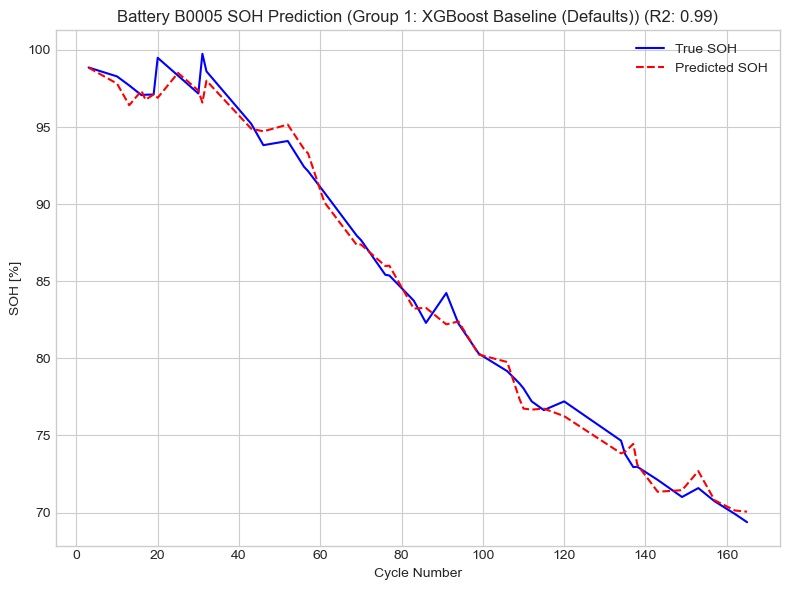


======== Running with Group 2: More Estimators, Slightly Deeper Trees (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 300, 'learning_rate': 0.1, 'max_depth': 5, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0, 'random_state': 42, 'n_jobs': -1}
  Số lượng mẫu huấn luyện: 126
  Số lượng mẫu kiểm thử: 42
  Đã thực hiện chuẩn hóa dữ liệu (fit trên train, transform trên cả train và test).
  Thời gian huấn luyện: 0.13 giây
  R-squared for B0005: 0.9893
  MAE for B0005: 0.7916
  RMSE for B0005: 1.0589


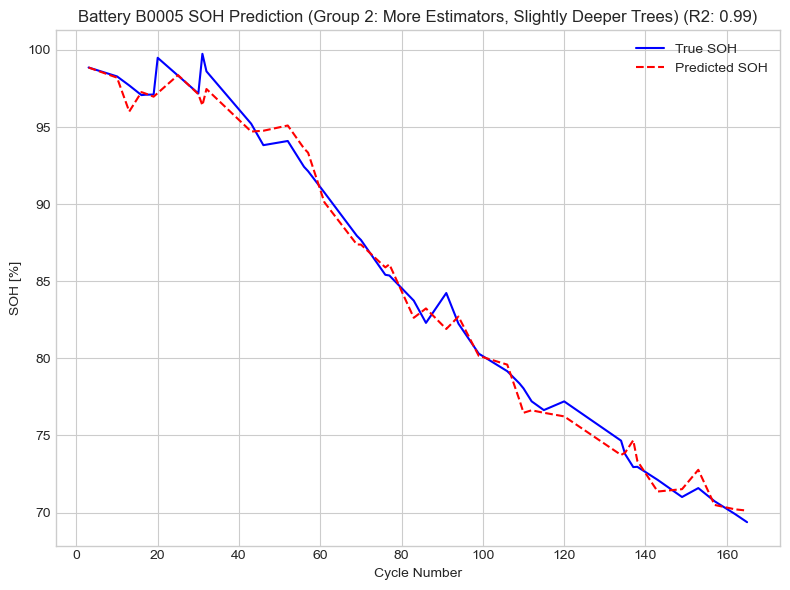


======== Running with Group 3: Slower Learning, More Trees, Subsampling (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 500, 'learning_rate': 0.05, 'max_depth': 6, 'subsample': 0.7, 'colsample_bytree': 0.7, 'gamma': 0, 'random_state': 42, 'n_jobs': -1}
  Số lượng mẫu huấn luyện: 126
  Số lượng mẫu kiểm thử: 42
  Đã thực hiện chuẩn hóa dữ liệu (fit trên train, transform trên cả train và test).
  Thời gian huấn luyện: 0.16 giây
  R-squared for B0005: 0.9916
  MAE for B0005: 0.6861
  RMSE for B0005: 0.9426


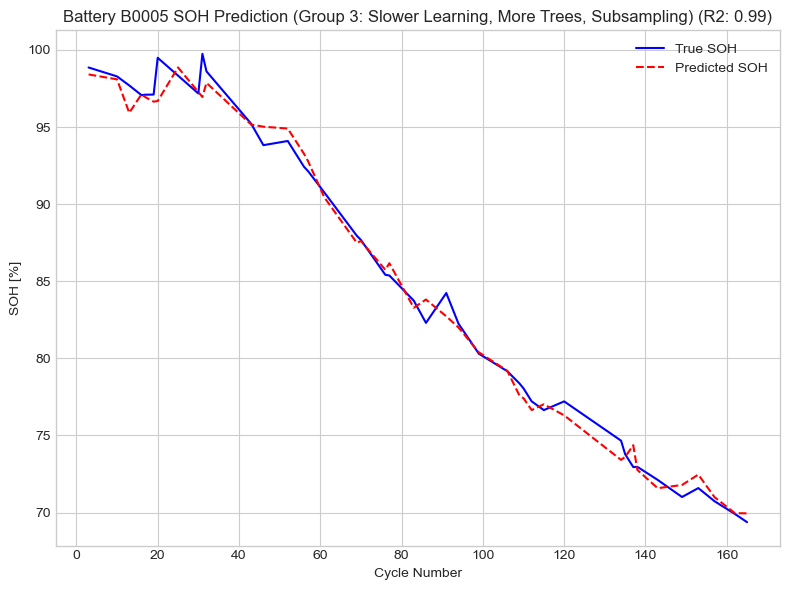


======== Running with Group 4: Stronger Regularization, More Trees (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 800, 'learning_rate': 0.02, 'max_depth': 7, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.1, 'reg_alpha': 0.005, 'reg_lambda': 0.5, 'random_state': 42, 'n_jobs': -1}
  Số lượng mẫu huấn luyện: 126
  Số lượng mẫu kiểm thử: 42
  Đã thực hiện chuẩn hóa dữ liệu (fit trên train, transform trên cả train và test).
  Thời gian huấn luyện: 0.16 giây
  R-squared for B0005: 0.9919
  MAE for B0005: 0.6769
  RMSE for B0005: 0.9204


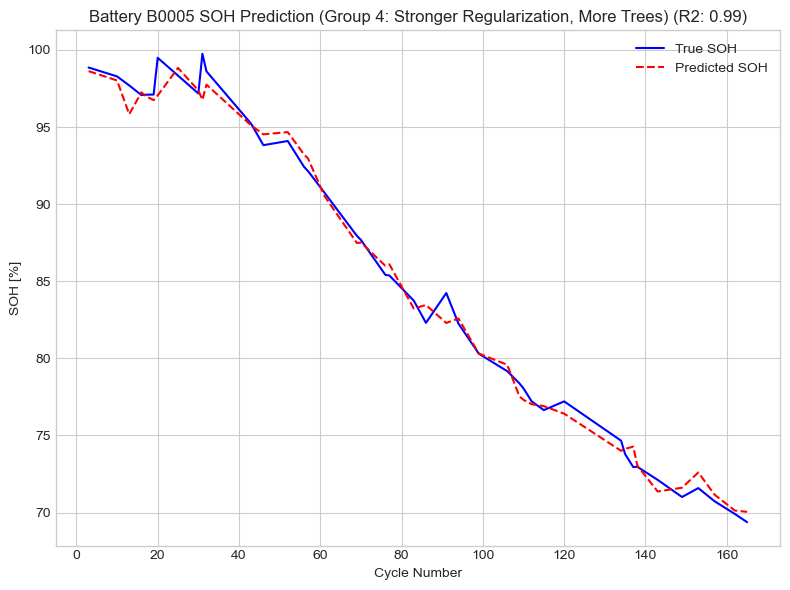


======== Running with Group 5: Very High Estimators & Fine-tuned (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 1200, 'learning_rate': 0.01, 'max_depth': 8, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.2, 'reg_alpha': 0.01, 'reg_lambda': 1.0, 'random_state': 42, 'n_jobs': -1}
  Số lượng mẫu huấn luyện: 126
  Số lượng mẫu kiểm thử: 42
  Đã thực hiện chuẩn hóa dữ liệu (fit trên train, transform trên cả train và test).
  Thời gian huấn luyện: 0.23 giây
  R-squared for B0005: 0.9916
  MAE for B0005: 0.7080
  RMSE for B0005: 0.9426


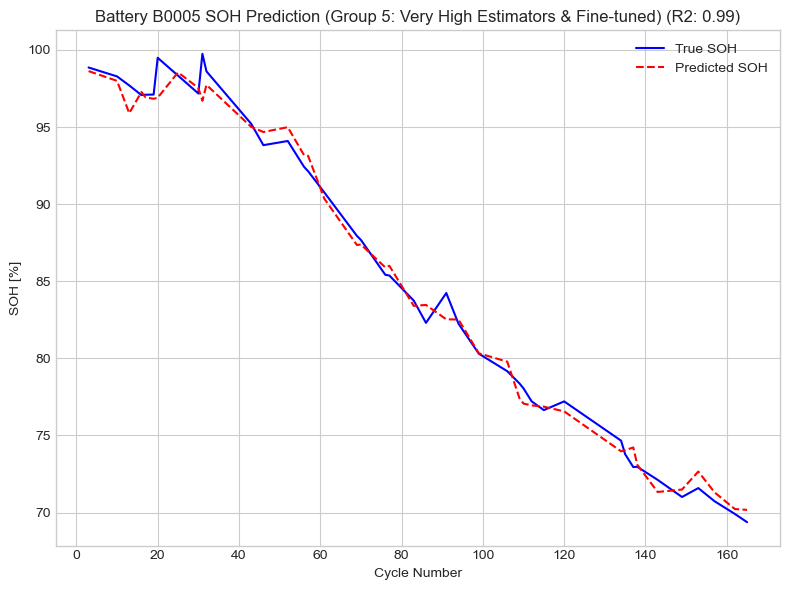

In [45]:
# Trích xuất X và Y cho pin B0005
X_B0005 = df_B0005[feature_columns]
y_B0005 = df_B0005[target_column]
cycles_B0005 = df_B0005[cycle_plot_column] # Để vẽ đồ thị

metrics_validate_xgb_B0005 = []
print(f"Tổng số mẫu cho pin B0005: {len(df_B0005)} chu kỳ")
print(f"Các đặc trưng đầu vào cho SOH: {feature_columns}")

print("--- Bắt đầu quy trình đánh giá SOH cho pin B0005 (chia ngẫu nhiên 75:25) ---")

# Lặp qua từng nhóm tham số Random Forest
for group_index, param_group in enumerate(param_groups_xgb):
    group_name = param_group['name']
    params = param_group['params']

    print(f"\n======== Running with {group_name} (RF Hyperparameters for SOH) ========")
    print(f"Parameters: {params}")

    # Khởi tạo mô hình Random Forest với các tham số của nhóm hiện tại
    xgb_model = XGBRegressor(**params)

    # Chia dữ liệu của pin B0005 75% huấn luyện : 25% kiểm thử ngẫu nhiên
    # random_state=42 để đảm bảo kết quả lặp lại
    X_train, X_test, y_train, y_test = train_test_split(
        X_B0005, y_B0005, test_size=0.25, random_state=42
    )

    print(f"  Số lượng mẫu huấn luyện: {len(X_train)}")
    print(f"  Số lượng mẫu kiểm thử: {len(X_test)}")
    scaler = StandardScaler()

    # 2. Fit scaler CHỈ trên dữ liệu huấn luyện (X_train)
    #    Điều này giúp scaler học các tham số (trung bình, độ lệch chuẩn) từ tập train.
    scaler.fit(X_train)

    # 3. Áp dụng phép biến đổi (transform) cho cả tập huấn luyện và tập kiểm thử
    #    Sử dụng cùng một scaler đã fit để đảm bảo tính nhất quán.
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print("  Đã thực hiện chuẩn hóa dữ liệu (fit trên train, transform trên cả train và test).")
    # --- KẾT THÚC PHẦN CHUẨN HÓA DỮ LIỆU ---
    start_time = time.time()
    # Huấn luyện mô hình Random Forest-
    xgb_model.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"  Thời gian huấn luyện: {training_time:.2f} giây")
    y_pred = xgb_model.predict(X_test)

    # Đánh giá hiệu suất
    battery_r2 = r2_score(y_test, y_pred)
    battery_mae = mean_absolute_error(y_test, y_pred)
    battery_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"  R-squared for B0005: {battery_r2:.4f}")
    print(f"  MAE for B0005: {battery_mae:.4f}")
    print(f"  RMSE for B0005: {battery_rmse:.4f}")
    metrics_validate_xgb_B0005.append({
        'group_name': group_name,
        'r2': battery_r2,
        'mae': battery_mae,
        'rmse': battery_rmse
    })
    # --- VẼ ĐỒ THỊ CHO PIN B0005 ---
    fig, ax = plt.subplots(figsize=(8, 6)) # Một figure cho mỗi nhóm tham số
    
    # Lấy chu kỳ từ original df_B0005 bằng cách dùng index của y_test
    # Sau đó sắp xếp để đường cong mượt
    test_cycle_data_for_plot = cycles_B0005.loc[y_test.index].sort_values()

    # Tạo DataFrame cho đồ thị
    plot_df = pd.DataFrame({
        'Cycle': test_cycle_data_for_plot,
        'True SOH': y_test.loc[test_cycle_data_for_plot.index], # Đảm bảo lấy đúng giá trị theo index đã sắp xếp
        'Predicted SOH': y_pred[np.argsort(y_test.index.values)] # Sắp xếp y_pred theo thứ tự index của y_test
    }).sort_values(by='Cycle')
    if group_index == 3: 
        result_stored_xgb.append(plot_df)
    sns.lineplot(x='Cycle', y='True SOH', data=plot_df, label='True SOH', color='blue', ax=ax)
    sns.lineplot(x='Cycle', y='Predicted SOH', data=plot_df, label='Predicted SOH', color='red', linestyle='--')
    
    ax.set_title(f'Battery B0005 SOH Prediction ({group_name}) (R2: {battery_r2:.2f})')
    ax.set_xlabel('Cycle Number')
    ax.set_ylabel('SOH [%]')
    ax.legend()
    ax.grid(True)
    
    plt.tight_layout()
    plt.show() 
    plt.close(fig) # Đóng figure để giải phóng bộ nhớ

Tổng số mẫu cho pin B0005: 168 chu kỳ
Các đặc trưng đầu vào cho SOH: ['Discharge_V_median', 'Discharge_T_std', 'Charge_T_std', 'Time_CC_phase']
--- Bắt đầu quy trình đánh giá SOH cho pin B0006 (chia ngẫu nhiên 75:25) ---

======== Running with Group 1: XGBoost Baseline (Defaults) (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0, 'random_state': 42, 'n_jobs': -1}
Số lượng mẫu huấn luyện: 126
Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.03 giây
R-squared for B0006: 0.9891
MAE for B0006: 0.8592
RMSE for B0006: 1.2982


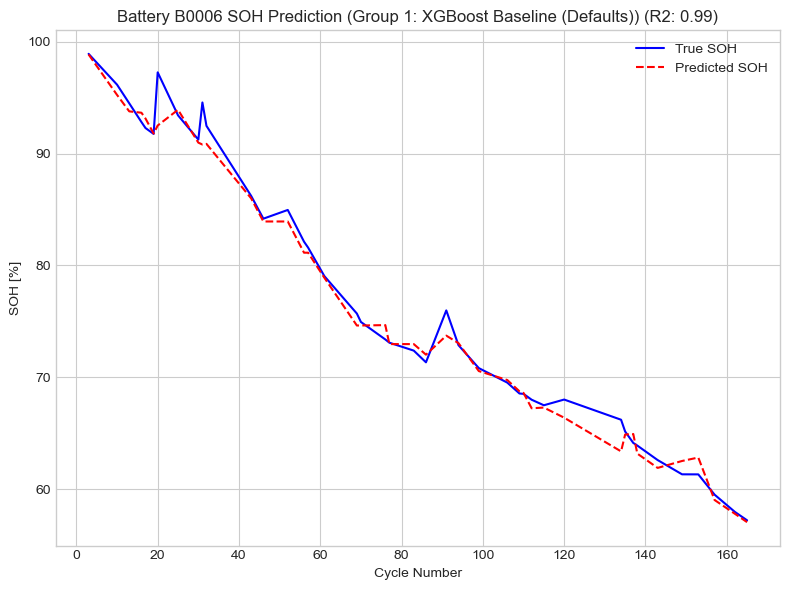


======== Running with Group 2: More Estimators, Slightly Deeper Trees (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 300, 'learning_rate': 0.1, 'max_depth': 5, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0, 'random_state': 42, 'n_jobs': -1}
Số lượng mẫu huấn luyện: 126
Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.09 giây
R-squared for B0006: 0.9900
MAE for B0006: 0.8780
RMSE for B0006: 1.2433


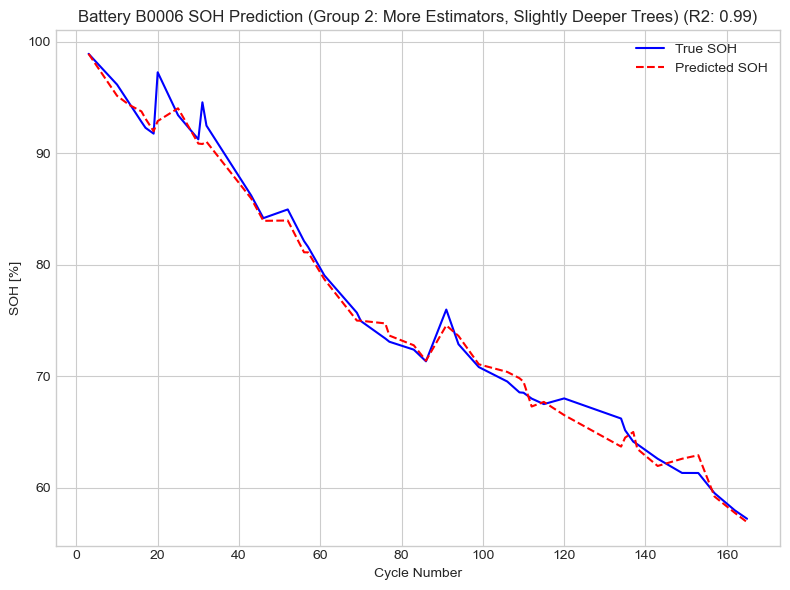


======== Running with Group 3: Slower Learning, More Trees, Subsampling (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 500, 'learning_rate': 0.05, 'max_depth': 6, 'subsample': 0.7, 'colsample_bytree': 0.7, 'gamma': 0, 'random_state': 42, 'n_jobs': -1}
Số lượng mẫu huấn luyện: 126
Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.21 giây
R-squared for B0006: 0.9854
MAE for B0006: 1.0328
RMSE for B0006: 1.4997


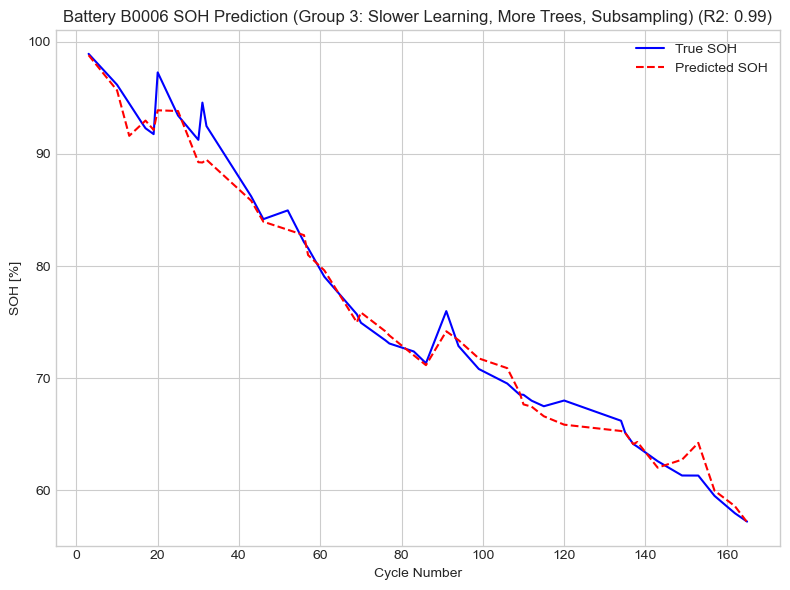


======== Running with Group 4: Stronger Regularization, More Trees (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 800, 'learning_rate': 0.02, 'max_depth': 7, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.1, 'reg_alpha': 0.005, 'reg_lambda': 0.5, 'random_state': 42, 'n_jobs': -1}
Số lượng mẫu huấn luyện: 126
Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.16 giây
R-squared for B0006: 0.9896
MAE for B0006: 0.8244
RMSE for B0006: 1.2664


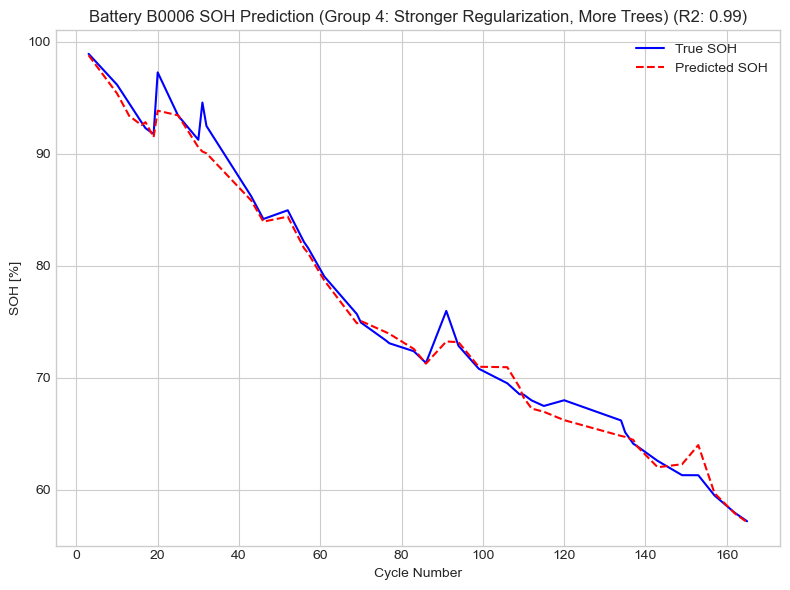


======== Running with Group 5: Very High Estimators & Fine-tuned (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 1200, 'learning_rate': 0.01, 'max_depth': 8, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.2, 'reg_alpha': 0.01, 'reg_lambda': 1.0, 'random_state': 42, 'n_jobs': -1}
Số lượng mẫu huấn luyện: 126
Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.25 giây
R-squared for B0006: 0.9889
MAE for B0006: 0.8665
RMSE for B0006: 1.3085


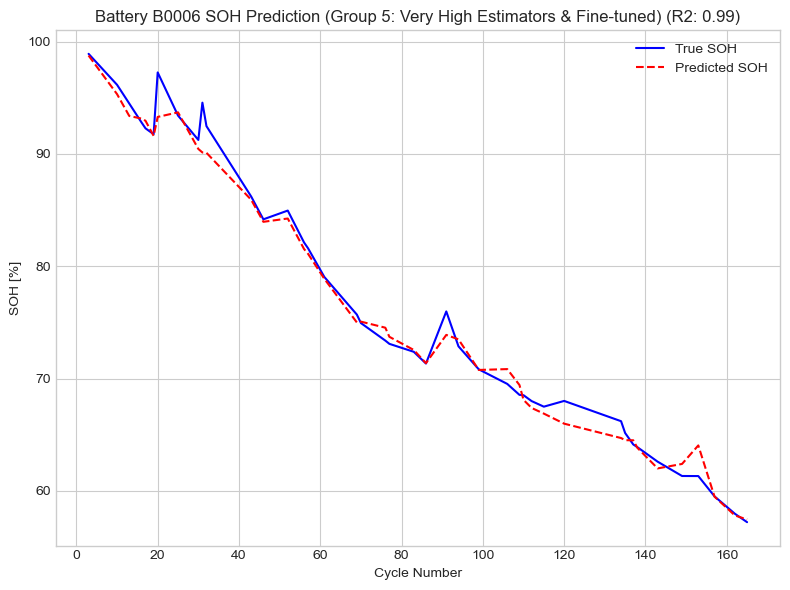

In [46]:
# Trích xuất X và Y cho pin B0006
X_B0006 = df_B0006[feature_columns]
y_B0006 = df_B0006[target_column]
cycles_B0006 = df_B0006[cycle_plot_column] # Để vẽ đồ thị

metrics_validate_xgb_B0006 = []
print(f"Tổng số mẫu cho pin B0005: {len(df_B0006)} chu kỳ")
print(f"Các đặc trưng đầu vào cho SOH: {feature_columns}")

print("--- Bắt đầu quy trình đánh giá SOH cho pin B0006 (chia ngẫu nhiên 75:25) ---")

# Lặp qua từng nhóm tham số Random Forest
for group_index, param_group in enumerate(param_groups_xgb):
    group_name = param_group['name']
    params = param_group['params']

    print(f"\n======== Running with {group_name} (RF Hyperparameters for SOH) ========")
    print(f"Parameters: {params}")

    # Khởi tạo mô hình Random Forest với các tham số của nhóm hiện tại
    xgb_model = XGBRegressor(**params)
    X_train, X_test, y_train, y_test = train_test_split(
        X_B0006, y_B0006, test_size=0.25, random_state=42
    )
    print(f"Số lượng mẫu huấn luyện: {len(X_train)}")
    print(f"Số lượng mẫu kiểm thử: {len(X_test)}")
    start_time = time.time()
    # Huấn luyện mô hình Random Forest-
    xgb_model.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"  Thời gian huấn luyện: {training_time:.2f} giây")
    y_pred = xgb_model.predict(X_test)
    # Đánh giá hiệu suất
    battery_r2 = r2_score(y_test, y_pred)
    battery_mae = mean_absolute_error(y_test, y_pred)
    battery_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"R-squared for B0006: {battery_r2:.4f}")
    print(f"MAE for B0006: {battery_mae:.4f}")
    print(f"RMSE for B0006: {battery_rmse:.4f}")
    metrics_validate_xgb_B0006.append({
        'group_name': group_name,
        'r2': battery_r2,
        'mae': battery_mae,
        'rmse': battery_rmse
    })
    # --- VẼ ĐỒ THỊ CHO PIN B0005 ---
    fig, ax = plt.subplots(figsize=(8, 6)) # Một figure cho mỗi nhóm tham số
    test_cycle_data_for_plot = cycles_B0006.loc[y_test.index].sort_values()
    # Tạo DataFrame cho đồ thị
    plot_df = pd.DataFrame({
        'Cycle': test_cycle_data_for_plot,
        'True SOH': y_test.loc[test_cycle_data_for_plot.index], # Đảm bảo lấy đúng giá trị theo index đã sắp xếp
        'Predicted SOH': y_pred[np.argsort(y_test.index.values)] # Sắp xếp y_pred theo thứ tự index của y_test
    }).sort_values(by='Cycle')
    if group_index == 3: 
        result_stored_xgb.append(plot_df)
    sns.lineplot(x='Cycle', y='True SOH', data=plot_df, label='True SOH', color='blue', ax=ax)
    sns.lineplot(x='Cycle', y='Predicted SOH', data=plot_df, label='Predicted SOH', color='red', linestyle='--') 
    ax.set_title(f'Battery B0006 SOH Prediction ({group_name}) (R2: {battery_r2:.2f})')
    ax.set_xlabel('Cycle Number')
    ax.set_ylabel('SOH [%]')
    ax.legend()
    ax.grid(True) 
    plt.tight_layout()
    plt.show() 
    plt.close(fig)

Tổng số mẫu cho pin B0005: 168 chu kỳ
Các đặc trưng đầu vào cho SOH: ['Discharge_V_median', 'Discharge_T_std', 'Charge_T_std', 'Time_CC_phase']
--- Bắt đầu quy trình đánh giá SOH cho pin B0006 (chia ngẫu nhiên 75:25) ---

======== Running with Group 1: XGBoost Baseline (Defaults) (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0, 'random_state': 42, 'n_jobs': -1}
Số lượng mẫu huấn luyện: 126
Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.03 giây
R-squared for B0007: 0.9808
MAE for B0007: 0.6372
RMSE for B0007: 1.1809


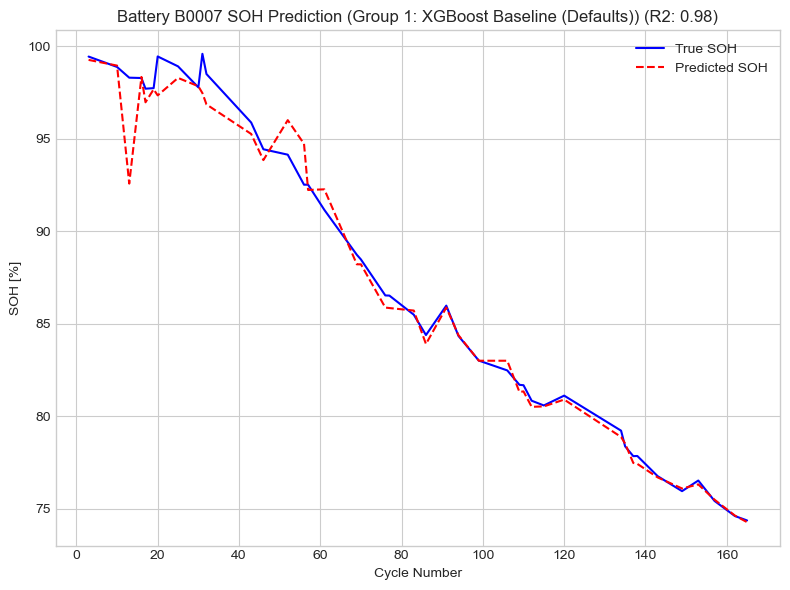


======== Running with Group 2: More Estimators, Slightly Deeper Trees (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 300, 'learning_rate': 0.1, 'max_depth': 5, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0, 'random_state': 42, 'n_jobs': -1}
Số lượng mẫu huấn luyện: 126
Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.12 giây
R-squared for B0007: 0.9837
MAE for B0007: 0.5800
RMSE for B0007: 1.0905


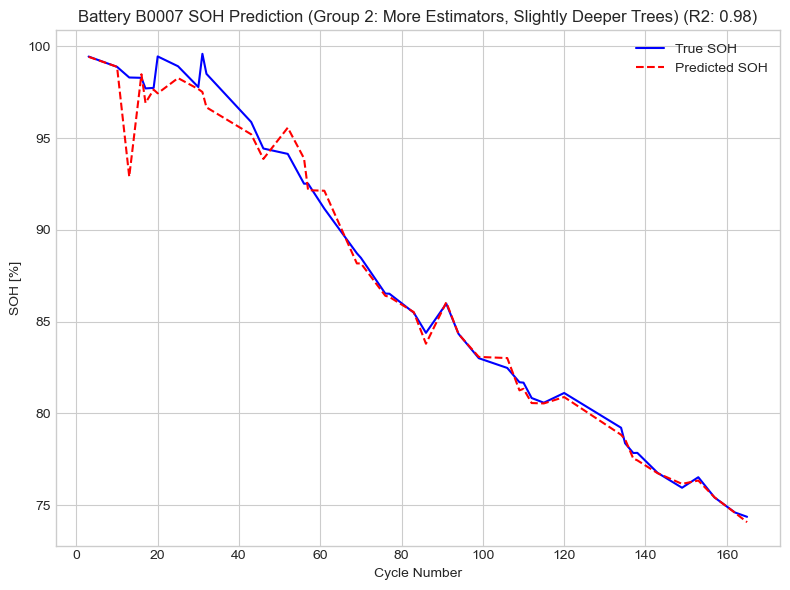


======== Running with Group 3: Slower Learning, More Trees, Subsampling (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 500, 'learning_rate': 0.05, 'max_depth': 6, 'subsample': 0.7, 'colsample_bytree': 0.7, 'gamma': 0, 'random_state': 42, 'n_jobs': -1}
Số lượng mẫu huấn luyện: 126
Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.18 giây
R-squared for B0007: 0.9846
MAE for B0007: 0.6239
RMSE for B0007: 1.0603


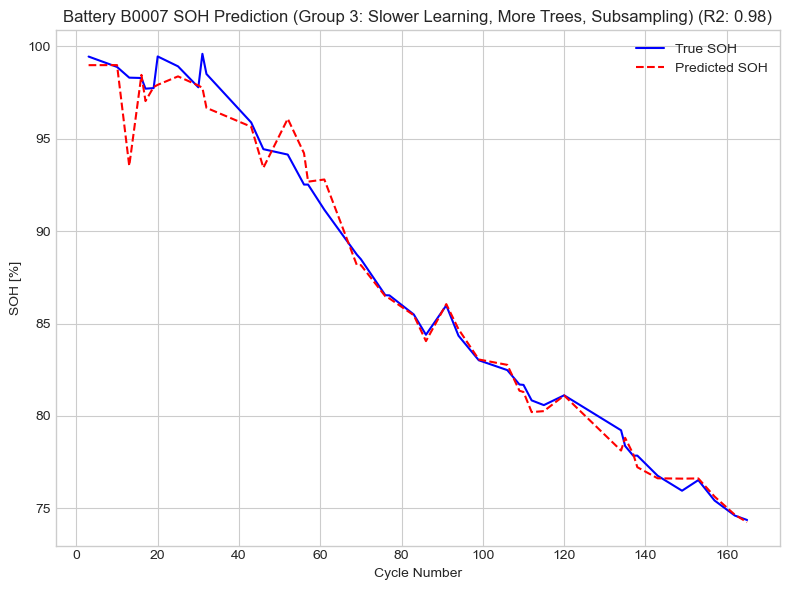


======== Running with Group 4: Stronger Regularization, More Trees (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 800, 'learning_rate': 0.02, 'max_depth': 7, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.1, 'reg_alpha': 0.005, 'reg_lambda': 0.5, 'random_state': 42, 'n_jobs': -1}
Số lượng mẫu huấn luyện: 126
Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.18 giây
R-squared for B0007: 0.9822
MAE for B0007: 0.5853
RMSE for B0007: 1.1396


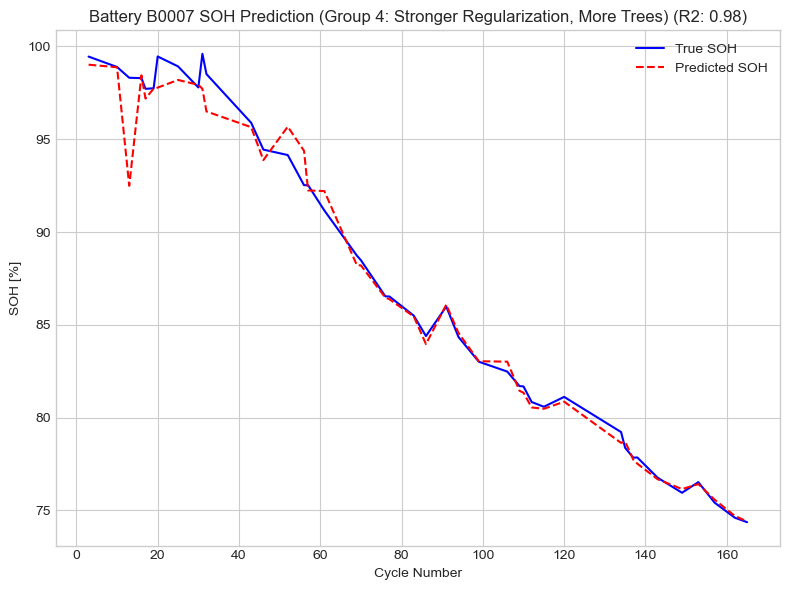


======== Running with Group 5: Very High Estimators & Fine-tuned (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 1200, 'learning_rate': 0.01, 'max_depth': 8, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.2, 'reg_alpha': 0.01, 'reg_lambda': 1.0, 'random_state': 42, 'n_jobs': -1}
Số lượng mẫu huấn luyện: 126
Số lượng mẫu kiểm thử: 42
  Thời gian huấn luyện: 0.25 giây
R-squared for B0007: 0.9783
MAE for B0007: 0.6356
RMSE for B0007: 1.2559


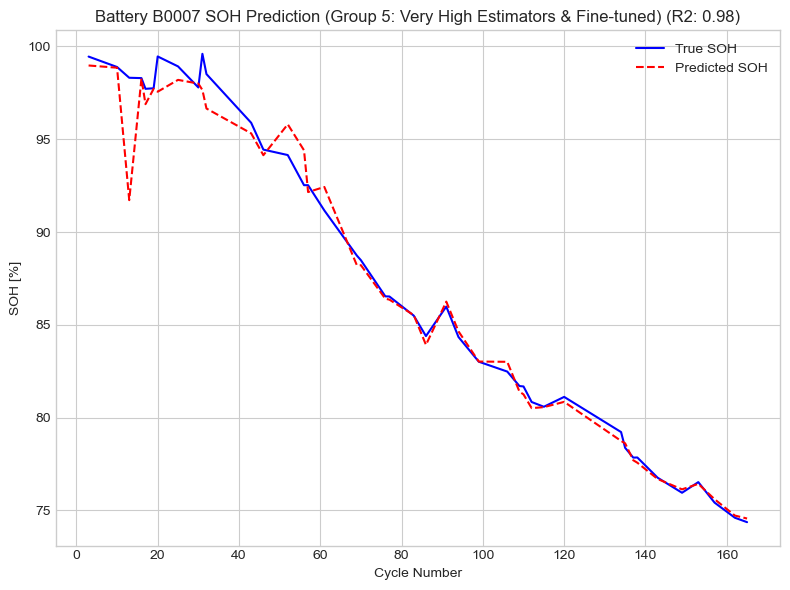

In [47]:
# Trích xuất X và Y cho pin B0007
X_B0007 = df_B0007[feature_columns]
y_B0007 = df_B0007[target_column]
cycles_B0007 = df_B0007[cycle_plot_column] # Để vẽ đồ thị

metrics_validate_xgb_B0007 = []
print(f"Tổng số mẫu cho pin B0005: {len(df_B0007)} chu kỳ")
print(f"Các đặc trưng đầu vào cho SOH: {feature_columns}")

print("--- Bắt đầu quy trình đánh giá SOH cho pin B0006 (chia ngẫu nhiên 75:25) ---")

# Lặp qua từng nhóm tham số Random Forest
for group_index, param_group in enumerate(param_groups_xgb):
    group_name = param_group['name']
    params = param_group['params']

    print(f"\n======== Running with {group_name} (RF Hyperparameters for SOH) ========")
    print(f"Parameters: {params}")

    # Khởi tạo mô hình Random Forest với các tham số của nhóm hiện tại
    xgb_model = XGBRegressor(**params)
    X_train, X_test, y_train, y_test = train_test_split(
        X_B0007, y_B0007, test_size=0.25, random_state=42
    )
    print(f"Số lượng mẫu huấn luyện: {len(X_train)}")
    print(f"Số lượng mẫu kiểm thử: {len(X_test)}")
    # Huấn luyện mô hình Random Forest-
    start_time = time.time()
    xgb_model.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"  Thời gian huấn luyện: {training_time:.2f} giây")
    y_pred = xgb_model.predict(X_test)
    # Đánh giá hiệu suất
    battery_r2 = r2_score(y_test, y_pred)
    battery_mae = mean_absolute_error(y_test, y_pred)
    battery_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"R-squared for B0007: {battery_r2:.4f}")
    print(f"MAE for B0007: {battery_mae:.4f}")
    print(f"RMSE for B0007: {battery_rmse:.4f}")
    metrics_validate_xgb_B0007.append({
        'group_name': group_name,
        'r2': battery_r2,
        'mae': battery_mae,
        'rmse': battery_rmse
    })
    # --- VẼ ĐỒ THỊ CHO PIN B0005 ---
    fig, ax = plt.subplots(figsize=(8, 6)) # Một figure cho mỗi nhóm tham số
    test_cycle_data_for_plot = cycles_B0007.loc[y_test.index].sort_values()
    # Tạo DataFrame cho đồ thị
    plot_df = pd.DataFrame({
        'Cycle': test_cycle_data_for_plot,
        'True SOH': y_test.loc[test_cycle_data_for_plot.index], # Đảm bảo lấy đúng giá trị theo index đã sắp xếp
        'Predicted SOH': y_pred[np.argsort(y_test.index.values)] # Sắp xếp y_pred theo thứ tự index của y_test
    }).sort_values(by='Cycle')
    if group_index == 3: 
        result_stored_xgb.append(plot_df)
    sns.lineplot(x='Cycle', y='True SOH', data=plot_df, label='True SOH', color='blue', ax=ax)
    sns.lineplot(x='Cycle', y='Predicted SOH', data=plot_df, label='Predicted SOH', color='red', linestyle='--') 
    ax.set_title(f'Battery B0007 SOH Prediction ({group_name}) (R2: {battery_r2:.2f})')
    ax.set_xlabel('Cycle Number')
    ax.set_ylabel('SOH [%]')
    ax.legend()
    ax.grid(True) 
    plt.tight_layout()
    plt.show() 
    plt.close(fig)

Tổng số mẫu cho pin B0005: 132 chu kỳ
Các đặc trưng đầu vào cho SOH: ['Discharge_V_median', 'Discharge_T_std', 'Charge_T_std', 'Time_CC_phase']
--- Bắt đầu quy trình đánh giá SOH cho pin B0018 (chia ngẫu nhiên 75:25) ---

======== Running with Group 1: XGBoost Baseline (Defaults) (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0, 'random_state': 42, 'n_jobs': -1}
Số lượng mẫu huấn luyện: 99
Số lượng mẫu kiểm thử: 33
  Thời gian huấn luyện: 0.03 giây
R-squared for B0018: 0.9810
MAE for B0018: 0.8242
RMSE for B0018: 1.1814


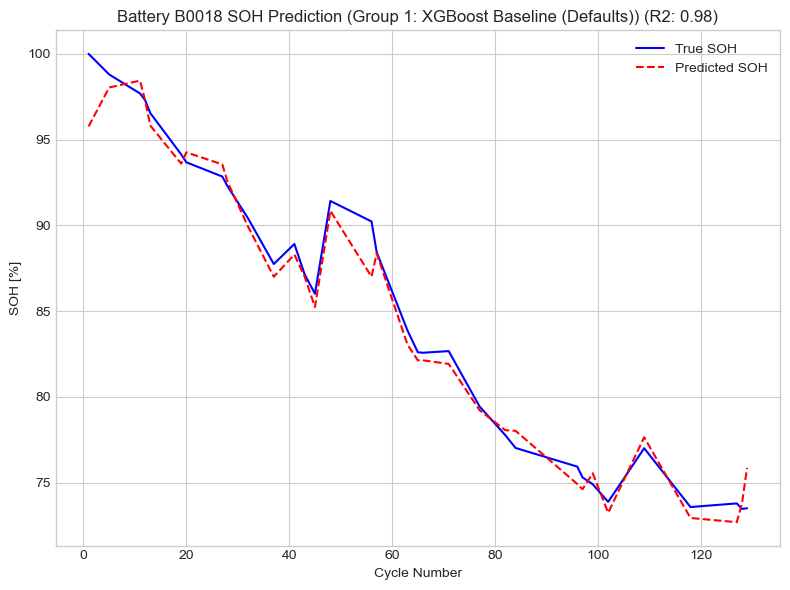


======== Running with Group 2: More Estimators, Slightly Deeper Trees (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 300, 'learning_rate': 0.1, 'max_depth': 5, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0, 'random_state': 42, 'n_jobs': -1}
Số lượng mẫu huấn luyện: 99
Số lượng mẫu kiểm thử: 33
  Thời gian huấn luyện: 0.11 giây
R-squared for B0018: 0.9798
MAE for B0018: 0.8322
RMSE for B0018: 1.2170


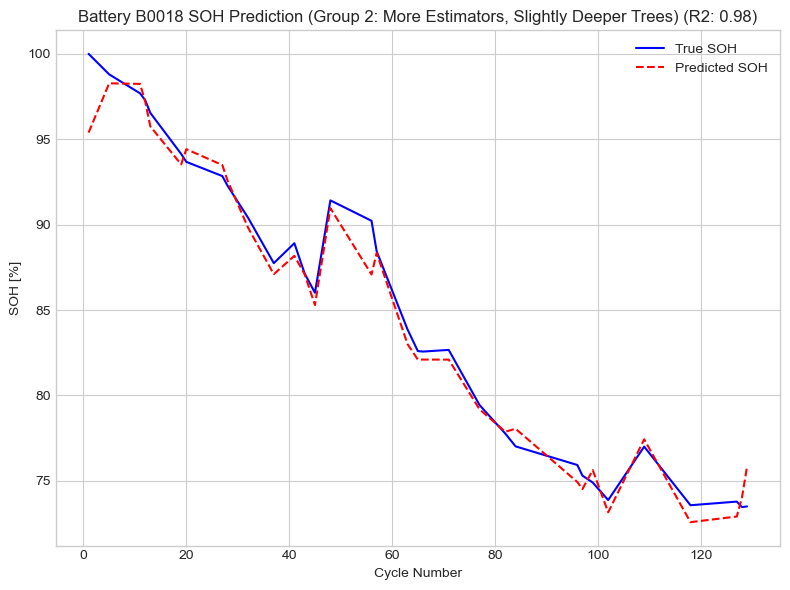


======== Running with Group 3: Slower Learning, More Trees, Subsampling (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 500, 'learning_rate': 0.05, 'max_depth': 6, 'subsample': 0.7, 'colsample_bytree': 0.7, 'gamma': 0, 'random_state': 42, 'n_jobs': -1}
Số lượng mẫu huấn luyện: 99
Số lượng mẫu kiểm thử: 33
  Thời gian huấn luyện: 0.16 giây
R-squared for B0018: 0.9822
MAE for B0018: 0.7687
RMSE for B0018: 1.1420


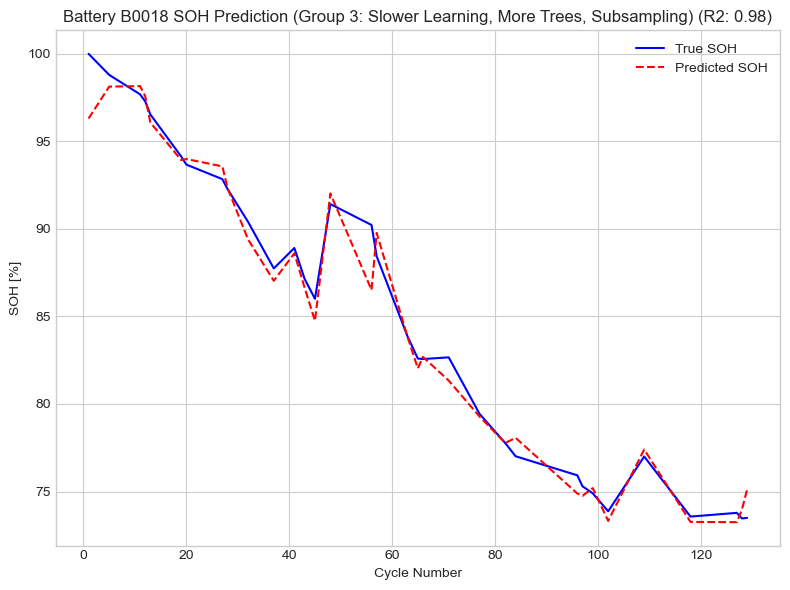


======== Running with Group 4: Stronger Regularization, More Trees (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 800, 'learning_rate': 0.02, 'max_depth': 7, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.1, 'reg_alpha': 0.005, 'reg_lambda': 0.5, 'random_state': 42, 'n_jobs': -1}
Số lượng mẫu huấn luyện: 99
Số lượng mẫu kiểm thử: 33
  Thời gian huấn luyện: 0.14 giây
R-squared for B0018: 0.9832
MAE for B0018: 0.7351
RMSE for B0018: 1.1115


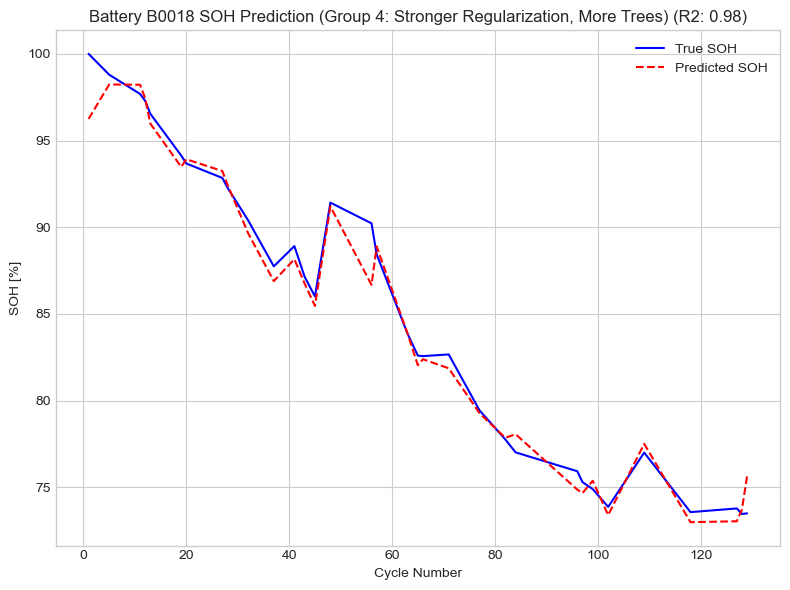


======== Running with Group 5: Very High Estimators & Fine-tuned (RF Hyperparameters for SOH) ========
Parameters: {'n_estimators': 1200, 'learning_rate': 0.01, 'max_depth': 8, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.2, 'reg_alpha': 0.01, 'reg_lambda': 1.0, 'random_state': 42, 'n_jobs': -1}
Số lượng mẫu huấn luyện: 99
Số lượng mẫu kiểm thử: 33
  Thời gian huấn luyện: 0.22 giây
R-squared for B0018: 0.9832
MAE for B0018: 0.7441
RMSE for B0018: 1.1105


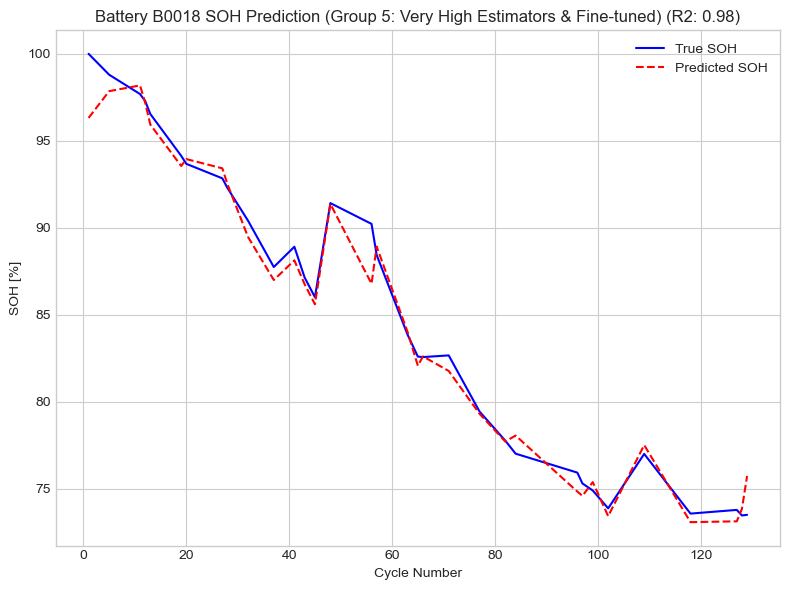

In [48]:
# Trích xuất X và Y cho pin B0008
X_B0018 = df_B0018[feature_columns]
y_B0018 = df_B0018[target_column]
cycles_B0018 = df_B0018[cycle_plot_column] # Để vẽ đồ thị

metrics_validate_xgb_B0018 = []
print(f"Tổng số mẫu cho pin B0005: {len(df_B0018)} chu kỳ")
print(f"Các đặc trưng đầu vào cho SOH: {feature_columns}")

print("--- Bắt đầu quy trình đánh giá SOH cho pin B0018 (chia ngẫu nhiên 75:25) ---")

# Lặp qua từng nhóm tham số Random Forest
for group_index, param_group in enumerate(param_groups_xgb):
    group_name = param_group['name']
    params = param_group['params']

    print(f"\n======== Running with {group_name} (RF Hyperparameters for SOH) ========")
    print(f"Parameters: {params}")

    # Khởi tạo mô hình Random Forest với các tham số của nhóm hiện tại
    xgb_model = XGBRegressor(**params)
    X_train, X_test, y_train, y_test = train_test_split(
        X_B0018, y_B0018, test_size=0.25, random_state=42
    )
    print(f"Số lượng mẫu huấn luyện: {len(X_train)}")
    print(f"Số lượng mẫu kiểm thử: {len(X_test)}")
    # Huấn luyện mô hình Random Forest-
    start_time = time.time()
    xgb_model.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"  Thời gian huấn luyện: {training_time:.2f} giây")
    y_pred = xgb_model.predict(X_test)
    # Đánh giá hiệu suất
    battery_r2 = r2_score(y_test, y_pred)
    battery_mae = mean_absolute_error(y_test, y_pred)
    battery_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"R-squared for B0018: {battery_r2:.4f}")
    print(f"MAE for B0018: {battery_mae:.4f}")
    print(f"RMSE for B0018: {battery_rmse:.4f}")
    metrics_validate_xgb_B0018.append({
        'group_name': group_name,
        'r2': battery_r2,
        'mae': battery_mae,
        'rmse': battery_rmse
    })
    # --- VẼ ĐỒ THỊ CHO PIN B0005 ---
    fig, ax = plt.subplots(figsize=(8, 6)) # Một figure cho mỗi nhóm tham số
    test_cycle_data_for_plot = cycles_B0018.loc[y_test.index].sort_values()
    # Tạo DataFrame cho đồ thị
    plot_df = pd.DataFrame({
        'Cycle': test_cycle_data_for_plot,
        'True SOH': y_test.loc[test_cycle_data_for_plot.index], # Đảm bảo lấy đúng giá trị theo index đã sắp xếp
        'Predicted SOH': y_pred[np.argsort(y_test.index.values)] # Sắp xếp y_pred theo thứ tự index của y_test
    }).sort_values(by='Cycle')
    if group_index == 3: 
        result_stored_xgb.append(plot_df)
    sns.lineplot(x='Cycle', y='True SOH', data=plot_df, label='True SOH', color='blue', ax=ax)
    sns.lineplot(x='Cycle', y='Predicted SOH', data=plot_df, label='Predicted SOH', color='red', linestyle='--') 
    ax.set_title(f'Battery B0018 SOH Prediction ({group_name}) (R2: {battery_r2:.2f})')
    ax.set_xlabel('Cycle Number')
    ax.set_ylabel('SOH [%]')
    ax.legend()
    ax.grid(True) 
    plt.tight_layout()
    plt.show() 
    plt.close(fig)

In [44]:
for i in range(5):
    print(f'Mean R-square group {i + 1}: ', (metrics_validate_xgb_B0018[i]['r2'] + metrics_validate_xgb_B0005[i]['r2'] + metrics_validate_xgb_B0006[i]['r2'] + metrics_validate_xgb_B0007[i]['r2']) / 4)
    print(f'Mean MAE group {i + 1}: ', (metrics_validate_xgb_B0005[i]['mae'] + metrics_validate_xgb_B0006[i]['mae'] + metrics_validate_xgb_B0007[i]['mae'] + metrics_validate_xgb_B0018[i]['mae']) / 4)
    print(f'Mean RMSE group {i + 1}: ', (metrics_validate_xgb_B0005[i]['rmse'] + metrics_validate_xgb_B0006[i]['rmse'] + metrics_validate_xgb_B0007[i]['rmse'] + metrics_validate_xgb_B0018[i]['rmse']) / 4)

Mean R-square group 1:  0.9854328323754249
Mean MAE group 1:  0.7618875828051983
Mean RMSE group 1:  1.160974989345749
Mean R-square group 2:  0.9857071665930135
Mean MAE group 2:  0.7704655975051733
Mean RMSE group 2:  1.1524233086659326
Mean R-square group 3:  0.9859462945006715
Mean MAE group 3:  0.7778806459679013
Mean RMSE group 3:  1.16117778561373
Mean R-square group 4:  0.9867244046524517
Mean MAE group 4:  0.7054299575448439
Mean RMSE group 4:  1.1094849379624574
Mean R-square group 5:  0.9855013108200416
Mean MAE group 5:  0.7385684624366087
Mean RMSE group 5:  1.154364410149094


In [49]:
print(type(result_stored_xgb[0]))

<class 'pandas.core.frame.DataFrame'>


In [53]:
result_stored_xgb[3].to_csv('./result/soh_split/soh_xgb_b0018.csv')

# STACKING ENSEMBLE

In [54]:
# --- Định nghĩa các nhóm/cấp độ siêu tham số cho từng base learner ---

param_levels = {
    'rf': {
        'simple': {
            'n_estimators': [100],
            'max_depth': [5, 10],
            'min_samples_split': [10],
            'min_samples_leaf': [5],
            'max_features': ['sqrt']
        },
        'moderate': {
            'n_estimators': [150, 200],
            'max_depth': [10, 15], # None cho phép cây phát triển đầy đủ
            'min_samples_split': [5, 10],
            'min_samples_leaf': [2, 4],
            'max_features': ['sqrt']
        },
        'complex': {
            'n_estimators': [200, 300],
            'max_depth': [15, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2],
            'max_features': ['sqrt'] # Thử cả tỷ lệ feature
        },
        'very_complex': {
            'n_estimators': [300, 500],
            'max_depth': [20, 30],
            'min_samples_split': [2],
            'min_samples_leaf': [1],
            'max_features': ['sqrt'] # 'auto' = all features
        }
    },
    'xgb': {
        'simple': {
            'n_estimators': [100],
            'learning_rate': [0.1],
            'max_depth': [3, 5],
            'subsample': [0.8],
            'colsample_bytree': [0.8],
            'gamma': [0, 0.1]
        },
        'moderate': {
            'n_estimators': [150, 200],
            'learning_rate': [0.05],
            'max_depth': [5, 7],
            'subsample': [0.7, 0.8],
            'colsample_bytree': [0.7, 0.8],
            'gamma': [0, 0.1],
            'reg_alpha': [0, 0.01],
            'reg_lambda': [1, 0.1] # Lambda thường > Alpha
        },
        'complex': {
            'n_estimators': [200, 300],
            'learning_rate': [0.01], # Learning rate nhỏ hơn với nhiều cây hơn
            'max_depth': [7, 9],
            'subsample': [0.6, 0.7],
            'colsample_bytree': [0.6, 0.7],
            'gamma': [0.1, 0.2],
            'reg_alpha': [0.01, 0.1],
            'reg_lambda': [0.1, 0.5]
        },
        'very_complex': {
            'n_estimators': [300, 500],
            'learning_rate': [0.01],
            'max_depth': [9, 12],
            'subsample': [0.5, 0.6],
            'colsample_bytree': [0.5, 0.6],
            'gamma': [0.2, 0.5],
            'reg_alpha': [0.1, 0.5],
            'reg_lambda': [0.5, 1]
        }
    },
    'svr': {
        'simple': {
            'C': [1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale'], # 'scale' là lựa chọn an toàn
            'epsilon': [0.1]
        },
        'moderate': {
            'C': [10, 50],
            'kernel': ['rbf', 'poly'],
            'gamma': ['scale', 'auto', 0.01],
            'epsilon': [0.05, 0.1],
            'degree': [2, 3] # Cho poly
        },
        'complex': {
            'C': [50, 100],
            'kernel': ['rbf', 'poly'],
            'gamma': [0.001, 0.01, 0.1], # Giá trị gamma cụ thể
            'epsilon': [0.01, 0.05],
            'degree': [3, 4]
        },
        'very_complex': {
            'C': [100, 200],
            'kernel': ['rbf'], # RBF thường linh hoạt nhất
            'gamma': [0.0001, 0.001, 0.01],
            'epsilon': [0.005, 0.01],
            # 'degree' không cần nếu chỉ dùng RBF
        }
    },
    'gpr': {
        # Tinh chỉnh GPR kernel phức tạp hơn, cần định nghĩa các kernel ứng viên
        # Ở đây, chúng ta sẽ tập trung vào các tham số alpha và n_restarts
        # và giả sử bạn sẽ định nghĩa một vài kernel candidates riêng
        'simple': {
            # 'kernel': [kernel_simple_1, kernel_simple_2], # Bạn cần định nghĩa các kernel này
            'alpha': [1e-5, 1e-3],
            'n_restarts_optimizer': [5]
        },
        'moderate': {
            # 'kernel': [kernel_moderate_1, kernel_moderate_2],
            'alpha': [1e-7, 1e-5],
            'n_restarts_optimizer': [10]
        },
        'complex': {
            # 'kernel': [kernel_complex_1, kernel_complex_2],
            'alpha': [1e-9, 1e-7],
            'n_restarts_optimizer': [15]
        },
        'very_complex': {
            # 'kernel': [kernel_very_complex_1, kernel_very_complex_2],
            'alpha': [1e-10, 1e-9],
            'n_restarts_optimizer': [20]
        }
    },
    'ridge': { # Siêu tham số cho Meta-Learner (Ridge Regression)
        'simple': {'alpha': [1.0, 5.0, 10.0]},
        'moderate': {'alpha': [0.1, 0.5, 1.0, 2.0]},
        'complex': {'alpha': [0.01, 0.05, 0.1, 0.5]}, # Alpha nhỏ hơn cho phép phức tạp hơn
        'very_complex': {'alpha': [0.001, 0.005, 0.01, 0.05]}
    }
}


In [55]:
# --- Cấp độ 'simple' ---
num_features = 7
from sklearn.gaussian_process.kernels import (
    RBF,
    Matern,
    RationalQuadratic,
    ExpSineSquared,
    DotProduct,
    ConstantKernel as C, # Đổi tên để tránh nhầm lẫn với hằng số C của SVR
    WhiteKernel,
    PairwiseKernel # Cho phép sử dụng các kernel của scikit-learn như linear, rbf, poly
)
# Kernel RBF đơn giản với length_scale vô hướng (isotropic)
kernel_gpr_simple_rbf = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) + \
                        WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-5, 1e1))

# Kernel Matern đơn giản (nu=1.5 là một lựa chọn phổ biến, ít "mượt" hơn RBF)
kernel_gpr_simple_matern = C(1.0, (1e-3, 1e3)) * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2), nu=1.5) + \
                           WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-5, 1e1))

# --- Cấp độ 'moderate' ---
# Kernel RBF với length_scale riêng cho từng chiều (anisotropic)
# Điều này rất quan trọng nếu các feature có thang đo hoặc tầm quan trọng khác nhau.
kernel_gpr_moderate_rbf_aniso = C(1.0, (1e-3, 1e3)) * RBF(length_scale=np.ones(num_features), length_scale_bounds=(1e-2, 1e2)) + \
                                WhiteKernel(noise_level=0.05, noise_level_bounds=(1e-5, 1e1))

# Kernel Matern anisotropic
kernel_gpr_moderate_matern_aniso = C(1.0, (1e-3, 1e3)) * Matern(length_scale=np.ones(num_features), length_scale_bounds=(1e-2, 1e2), nu=1.5) + \
                                   WhiteKernel(noise_level=0.05, noise_level_bounds=(1e-5, 1e1))

# Kernel Rational Quadratic (có thể nắm bắt các biến đổi ở nhiều thang đo)
kernel_gpr_moderate_rq = C(1.0, (1e-3, 1e3)) * RationalQuadratic(length_scale=1.0, alpha=0.1, length_scale_bounds=(1e-2,1e2), alpha_bounds=(1e-2,1e2)) + \
                         WhiteKernel(noise_level=0.05, noise_level_bounds=(1e-5, 1e1))

# --- Cấp độ 'complex' ---
# Kết hợp RBF anisotropic và một kernel DotProduct (tuyến tính)
# Có thể hữu ích nếu có cả thành phần phi tuyến và tuyến tính trong dữ liệu
kernel_gpr_complex_rbf_dot = C(1.0) * RBF(length_scale=np.ones(num_features), length_scale_bounds=(1e-1, 1e1)) + \
                             C(1.0) * DotProduct(sigma_0=1.0, sigma_0_bounds=(1e-2, 1e2)) + \
                             WhiteKernel(noise_level=0.01, noise_level_bounds=(1e-5, 1e0))

# Kernel RBF với length_scale bounds chặt hơn, cho phép tinh chỉnh kỹ hơn
kernel_gpr_complex_rbf_tight_bounds = C(1.0, (1e-2, 1e2)) * RBF(length_scale=np.ones(num_features), length_scale_bounds=(1e-1, 1e1)) + \
                                      WhiteKernel(noise_level=0.01, noise_level_bounds=(1e-5, 1e0))


# Kernel ExpSineSquared (cho dữ liệu có tính chu kỳ, có thể không phù hợp lắm với SOH trừ khi có yếu tố chu kỳ mạnh)
# Ở đây chỉ để minh họa sự đa dạng. Cần điều chỉnh `periodicity`.
# kernel_gpr_complex_expsine = C(1.0) * ExpSineSquared(length_scale=1.0, periodicity=10.0, # periodicity cần được ước lượng từ dữ liệu
# length_scale_bounds=(1e-1,1e1), periodicity_bounds=(1.0, 50.0)
#                                                       ) + \
#                              WhiteKernel(noise_level=0.01)

# --- Cấp độ 'very_complex' ---
# Một kernel phức tạp hơn bằng cách cộng nhiều thành phần RBF với các length_scale khác nhau (ARD - Automatic Relevance Determination)
# Điều này cho phép mô hình nắm bắt các cấu trúc ở các "tần số" khác nhau.
kernel_gpr_very_complex_sum_rbf = C(1.0) * RBF(length_scale=np.ones(num_features)*0.5, length_scale_bounds=(1e-2, 1e1)) + \
                                  C(1.0) * RBF(length_scale=np.ones(num_features)*2.0, length_scale_bounds=(1e-1, 1e2)) + \
                                  WhiteKernel(noise_level=0.005, noise_level_bounds=(1e-6, 1e-1))

# Kết hợp Matern (nu=2.5, mượt hơn nu=1.5) với một thành phần tuyến tính
kernel_gpr_very_complex_matern_dot = C(1.0) * Matern(length_scale=np.ones(num_features), nu=2.5, length_scale_bounds=(1e-2, 1e1)) + \
                                     C(1.0) * DotProduct(sigma_0=0.5, sigma_0_bounds=(1e-3, 1e1)) + \
                                     WhiteKernel(noise_level=0.005, noise_level_bounds=(1e-6, 1e-1))

# Sử dụng PairwiseKernel để bọc một kernel RBF từ scikit-learn (chỉ để minh họa, thường dùng RBF trực tiếp của GPR tốt hơn)
# from sklearn.metrics.pairwise import rbf_kernel
# kernel_gpr_very_complex_pairwise = C(1.0) * PairwiseKernel(gamma=0.1, metric='rbf') + \
# WhiteKernel(noise_level=0.005)

# --- Cập nhật param_levels['gpr']['kernel'] ---
# Tạo một kernel mặc định an toàn phòng trường hợp num_features không đúng
default_gpr_kernel = C(1.0) * RBF(length_scale=1.0) + WhiteKernel(noise_level=0.1)

if 'param_levels' not in globals(): # Nếu param_levels chưa được định nghĩa ở đâu đó
    param_levels = {'gpr': {level: {} for level in ['simple', 'moderate', 'complex', 'very_complex']}}


param_levels['gpr']['simple']['kernel'] = [kernel_gpr_simple_rbf, kernel_gpr_simple_matern]
param_levels['gpr']['moderate']['kernel'] = [kernel_gpr_moderate_rbf_aniso, kernel_gpr_moderate_matern_aniso, kernel_gpr_moderate_rq]
param_levels['gpr']['complex']['kernel'] = [kernel_gpr_moderate_rbf_aniso, kernel_gpr_moderate_matern_aniso, kernel_gpr_moderate_rq]# Bỏ ExpSine nếu không chắc
param_levels['gpr']['very_complex']['kernel'] = [kernel_gpr_moderate_rbf_aniso, kernel_gpr_moderate_matern_aniso, kernel_gpr_moderate_rq]

# Đảm bảo các cấp độ GPR khác trong param_levels cũng được khởi tạo nếu cần
for model_name in ['rf', 'xgb', 'svr', 'ridge']:
    if model_name not in param_levels:
        param_levels[model_name] = {level: {} for level in ['simple', 'moderate', 'complex', 'very_complex']}



if 'param_levels' in globals(): # Chỉ chạy nếu param_levels đã được định nghĩa
    param_levels['gpr']['simple'].update({
        'alpha': [1e-5, 1e-3],
        'n_restarts_optimizer': [5]
    })
    param_levels['gpr']['moderate'].update({
        'alpha': [1e-7, 1e-5],
        'n_restarts_optimizer': [10]
    })
    param_levels['gpr']['complex'].update({
        'alpha': [1e-9, 1e-7],
        'n_restarts_optimizer': [15]
    })
    param_levels['gpr']['very_complex'].update({
        'alpha': [1e-10, 1e-9],
        'n_restarts_optimizer': [20]
    })

    # In ra để kiểm tra một cấp độ
    print("\nVí dụ tham số GPR 'moderate' sau khi thêm kernel và alpha/n_restarts:")
    print(param_levels['gpr']['moderate'])

else:
    print("Cảnh báo: 'param_levels' chưa được định nghĩa. Không thể cập nhật alpha và n_restarts cho GPR.")


Ví dụ tham số GPR 'moderate' sau khi thêm kernel và alpha/n_restarts:
{'alpha': [1e-07, 1e-05], 'n_restarts_optimizer': [10], 'kernel': [1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1]) + WhiteKernel(noise_level=0.05), 1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1], nu=1.5) + WhiteKernel(noise_level=0.05), 1**2 * RationalQuadratic(alpha=0.1, length_scale=1) + WhiteKernel(noise_level=0.05)]}


In [56]:

# --- BƯỚC 1: KHỞI TẠO BASE LEARNERS (CHỈ LÀ TEMPLATE BAN ĐẦU) ---
rf_model_template = RandomForestRegressor(random_state=42, n_jobs=-1)
xgb_model_template = XGBRegressor(random_state=42, n_jobs=-1, objective='reg:squarederror')
svr_model_template = SVR()
gpr_model_template = GaussianProcessRegressor(random_state=42) # Kernel sẽ được set bởi GridSearchCV

base_learner_templates = [ # Danh sách các template ban đầu
    ('rf', rf_model_template),
    ('xgb', xgb_model_template),
    ('svr', svr_model_template),
    ('gpr', gpr_model_template)
]
# Nếu không có feature, loại bỏ GPR
if num_features == 0 and 'gpr' in [name for name,_ in base_learner_templates]:
    base_learner_templates = [tpl for tpl in base_learner_templates if tpl[0] != 'gpr']
    print("CẢNH BÁO: GPR đã bị loại bỏ do không có features.")

In [57]:
metrics_validate_B0005 = []
metrics_validate_B0006 = []
metrics_validate_B0007 = []
metrics_validate_B0018 = []

In [72]:
X_full = df_B0007[feature_columns]
y_full = df_B0007[target_column]
groups_full = df_B0007[group_column]

# Tính toán số lượng features
num_features = X_full.shape[1] # <<< ĐỊNH NGHĨA num_features TỪ X_full
# --- 2. CHIA TẬP DỮ LIỆU TRAINING/TESTING (75% TRAIN, 25% TEST) ---
print("--- Chia dữ liệu Training (75%) và Testing (25%) ---")
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(
    X_full, y_full, groups_full, test_size=0.25, random_state=42, shuffle=True
)

print(f"Kích thước X_train: {X_train.shape}")
print(f"Kích thước X_test: {X_test.shape}")
print(f"Kích thước y_train: {y_train.shape}")
print(f"Kích thước y_test: {y_test.shape}")
print(f"Số lượng nhóm duy nhất trong tập train: {groups_train.nunique()}")
print(f"Số lượng nhóm duy nhất trong tập test: {groups_test.nunique()}")

--- Chia dữ liệu Training (75%) và Testing (25%) ---
Kích thước X_train: (126, 4)
Kích thước X_test: (42, 4)
Kích thước y_train: (126,)
Kích thước y_test: (42,)
Số lượng nhóm duy nhất trong tập train: 1
Số lượng nhóm duy nhất trong tập test: 1


# Training base model

In [73]:
current_level_to_try = 'simple'
print(f"\n--- SỬ DỤNG CẤP ĐỘ THAM SỐ: {current_level_to_try.upper()} ---")


# --- 3. HUẤN LUYỆN BASE LEARNERS VÀ TẠO META-FEATURES ---
print("\n--- Bắt đầu huấn luyện Base Learners và tạo Meta-Features ---")
start_time_base_learners = time.time()

# Khởi tạo mảng để lưu trữ dự đoán của base learners
oof_predictions_base_train = np.zeros((len(X_train), len(base_learner_templates)))
test_predictions_base = np.zeros((len(X_test), len(base_learner_templates)))
best_params_per_learner = [] # Lưu trữ best_params cho mỗi base learner

# Inner CV sẽ luôn là KFold vì chỉ có một battery_id trong df_B0005
n_inner_cv_splits = min(5, len(X_train)) # Sử dụng 5 fold cho inner CV, hoặc ít hơn nếu X_train nhỏ
if n_inner_cv_splits == 0: n_inner_cv_splits = 1 # Đảm bảo ít nhất 1 split
inner_cv = KFold(n_splits=n_inner_cv_splits, shuffle=True, random_state=42)
print(f"  Inner CV cho Base Learners: KFold với {inner_cv.n_splits} splits")

for i_learner, (learner_name, model_template) in enumerate(base_learner_templates):
    start_time_learner = time.time()
    print(f"\n  Tinh chỉnh và huấn luyện Base Learner: {learner_name}")

    if learner_name not in param_levels or current_level_to_try not in param_levels[learner_name]:
        print(f"Cảnh báo: Không tìm thấy param grid cho {learner_name} ở level {current_level_to_try}. Bỏ qua.")
        oof_predictions_base_train[:, i_learner] = np.nan
        test_predictions_base[:, i_learner] = np.nan
        continue

    param_grid_learner = param_levels[learner_name][current_level_to_try]

    grid_search_cv = GridSearchCV(
        estimator=clone(model_template),
        param_grid=param_grid_learner,
        scoring='neg_root_mean_squared_error',
        cv=inner_cv, # KFold trên X_train
        n_jobs=1,
        verbose=0
    )

    try:
        grid_search_cv.fit(X_train, y_train) # Không cần groups vì dùng KFold

        best_model_for_learner = grid_search_cv.best_estimator_

        # Tạo meta-features: dự đoán trên X_train và X_test
        oof_predictions_base_train[:, i_learner] = best_model_for_learner.predict(X_train)
        test_predictions_base[:, i_learner] = best_model_for_learner.predict(X_test)

        print(f"    Best params cho {learner_name}: {grid_search_cv.best_params_}")
        print(f"    Best CV score (neg_RMSE): {grid_search_cv.best_score_:.4f}")
        best_params_per_learner.append({
            'learner': learner_name,
            'best_params': grid_search_cv.best_params_,
            'best_cv_score': grid_search_cv.best_score_
        })

    except Exception as e:
        print(f"    LỖI với GridSearchCV cho {learner_name}: {e}")
        oof_predictions_base_train[:, i_learner] = np.nan
        test_predictions_base[:, i_learner] = np.nan

    end_time_learner = time.time()
    print(f"    Thời gian cho {learner_name}: {end_time_learner - start_time_learner:.2f} giây")

end_time_base_learners = time.time()
print(f"\nHoàn thành huấn luyện Base Learners. Tổng thời gian: {end_time_base_learners - start_time_base_learners:.2f} giây")

best_params_df = pd.DataFrame(best_params_per_learner)
print("\n--- Siêu tham số tốt nhất cho Base Learners ---")
print(best_params_df)

# Chuyển đổi thành DataFrame và xử lý NaN nếu có
meta_features_for_meta_train = pd.DataFrame(oof_predictions_base_train, columns=[name for name, _ in base_learner_templates])
meta_features_for_meta_test = pd.DataFrame(test_predictions_base, columns=[name for name, _ in base_learner_templates])

for col in meta_features_for_meta_train.columns:
    if meta_features_for_meta_train[col].isnull().any():
        print(f"Cảnh báo: Tìm thấy NaN trong meta-features train của {col}. Điền bằng giá trị trung bình.")
        if not meta_features_for_meta_train[col].isnull().all():
            mean_val = meta_features_for_meta_train[col].mean()
            meta_features_for_meta_train[col].fillna(mean_val, inplace=True)
            meta_features_for_meta_test[col].fillna(mean_val, inplace=True) # Điền giá trị trung bình từ tập train
        else: # Nếu tất cả đều NaN
            meta_features_for_meta_train[col].fillna(0, inplace=True)
            meta_features_for_meta_test[col].fillna(0, inplace=True)



--- SỬ DỤNG CẤP ĐỘ THAM SỐ: SIMPLE ---

--- Bắt đầu huấn luyện Base Learners và tạo Meta-Features ---
  Inner CV cho Base Learners: KFold với 5 splits

  Tinh chỉnh và huấn luyện Base Learner: rf
    Best params cho rf: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}
    Best CV score (neg_RMSE): -1.1687
    Thời gian cho rf: 1.22 giây

  Tinh chỉnh và huấn luyện Base Learner: xgb
    Best params cho xgb: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
    Best CV score (neg_RMSE): -0.9340
    Thời gian cho xgb: 0.59 giây

  Tinh chỉnh và huấn luyện Base Learner: svr
    Best params cho svr: {'C': 10, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
    Best CV score (neg_RMSE): -0.9532
    Thời gian cho svr: 9.64 giây

  Tinh chỉnh và huấn luyện Base Learner: gpr
    Best params cho gpr: {'alpha': 0.001, 'kernel': 1**2 * RBF(length_scale=1) + WhiteKernel(

# META LEARNER

In [74]:
# --- 4. TINH CHỈNH VÀ HUẤN LUYỆN META-LEARNER (Ridge Regression) ---
print("\n--- Tinh chỉnh siêu tham số cho Meta-Learner (Ridge) ---")
meta_learner_template = Ridge(random_state=42)
param_grid_meta = param_levels['ridge'][current_level_to_try]

# CV cho meta-learner: KFold trên tập huấn luyện
n_meta_cv_splits = min(5, len(meta_features_for_meta_train))
if n_meta_cv_splits == 0: n_meta_cv_splits = 1
cv_meta = KFold(n_splits=n_meta_cv_splits, shuffle=True, random_state=42)
print(f"  CV cho Meta-Learner: KFold với {cv_meta.n_splits} splits")

grid_search_meta = GridSearchCV(
    estimator=meta_learner_template,
    param_grid=param_grid_meta,
    scoring='neg_root_mean_squared_error',
    cv=cv_meta,
    n_jobs=1,
    verbose=1
)

if meta_features_for_meta_train.empty or y_train.empty:
    print("Cảnh báo: Dữ liệu meta-features hoặc target train rỗng, không thể tinh chỉnh Meta-Learner.")
else:
    grid_search_meta.fit(meta_features_for_meta_train, y_train) # Huấn luyện trên meta-features từ X_train

    best_meta_learner = grid_search_meta.best_estimator_
    print(f"\nMeta-Learner tốt nhất: {best_meta_learner}")
    print(f"Hệ số của Meta-Learner tốt nhất: {best_meta_learner.coef_}")
    print(f"Best CV score (neg_RMSE) cho Meta-Learner: {grid_search_meta.best_score_:.4f}")


    # --- 5. ĐÁNH GIÁ MÔ HÌNH STACKING TỔNG THỂ TRÊN TẬP TEST ---
    print("\n--- Đánh giá Mô hình STACKING trên tập TEST ---")
    final_stacking_predictions = best_meta_learner.predict(meta_features_for_meta_test)

    # Tính toán các chỉ số
    test_rmse_stacking = np.sqrt(mean_squared_error(y_test, final_stacking_predictions))
    test_r2_stacking = r2_score(y_test, final_stacking_predictions)
    test_mae_stacking = mean_absolute_error(y_test, final_stacking_predictions)

    print(f"  RMSE trên tập TEST: {test_rmse_stacking:.4f}")
    print(f"  R2 score trên tập TEST: {test_r2_stacking:.4f}")
    print(f"  MAE trên tập TEST: {test_mae_stacking:.4f}")


    print(len(final_stacking_predictions))


--- Tinh chỉnh siêu tham số cho Meta-Learner (Ridge) ---
  CV cho Meta-Learner: KFold với 5 splits
Fitting 5 folds for each of 3 candidates, totalling 15 fits

Meta-Learner tốt nhất: Ridge(random_state=42)
Hệ số của Meta-Learner tốt nhất: [-1.01540508e-02  1.08026958e+00  7.80711895e-04 -7.04967465e-02]
Best CV score (neg_RMSE) cho Meta-Learner: -0.1425

--- Đánh giá Mô hình STACKING trên tập TEST ---
  RMSE trên tập TEST: 1.1100
  R2 score trên tập TEST: 0.9831
  MAE trên tập TEST: 0.6427
42


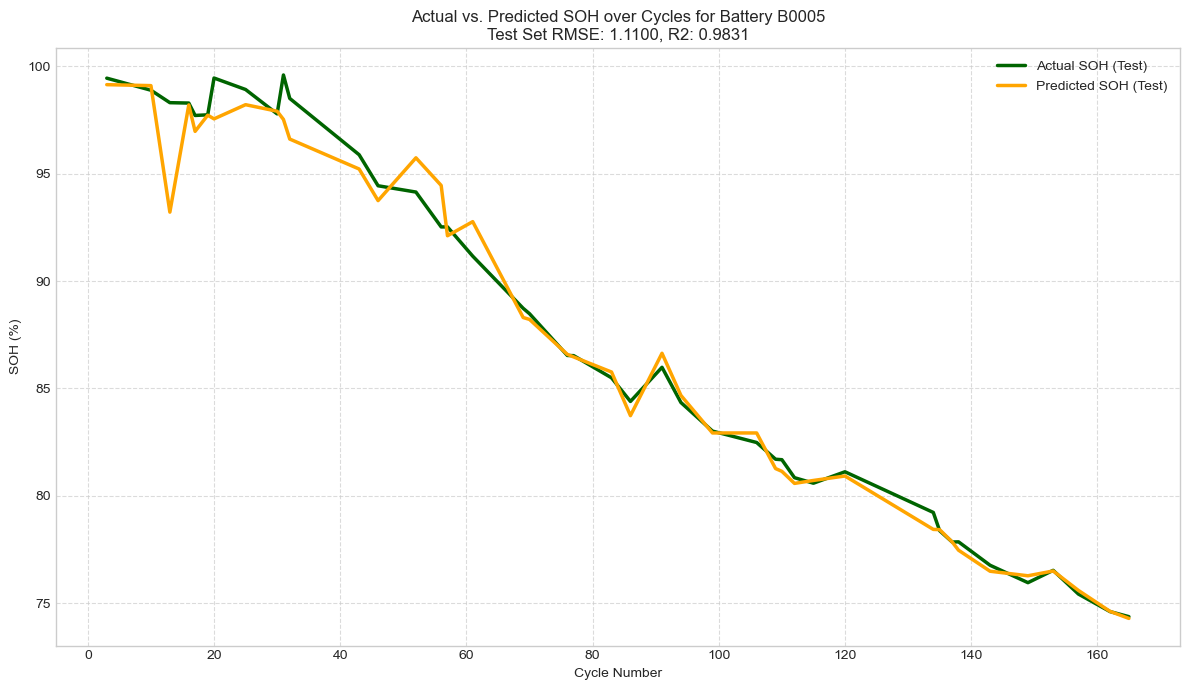

In [75]:

if y_test.empty or y_train.empty or final_stacking_predictions.size == 0:
    print("Không thể vẽ đồ thị SOH/CYCLE: Dữ liệu huấn luyện hoặc kiểm tra rỗng / không có dự đoán.")
else:
    # --- 1. Tạo DataFrame cho dữ liệu Test Set ---
    # train_test_split giữ nguyên index gốc, nên ta có thể dùng y_test.index
    # để lấy lại cột 'cycle' từ df_B0005 gốc.
    plot_df_test = pd.DataFrame({
        'cycle': df_B0007.loc[y_test.index, 'cycle'], # Lấy cột 'cycle' tương ứng
        'actual_soh': y_test,
        'predicted_soh': final_stacking_predictions
    })
    plot_df_test.to_csv('./result/soh_split/soh_st_b0007.csv')
    # Sắp xếp theo cycle để đường đồ thị mượt mà hơn
    plot_df_test = plot_df_test.sort_values(by='cycle')
    # --- 3. Vẽ đồ thị ---
    plt.figure(figsize=(12, 7)) # Kích thước lớn hơn cho dễ nhìn

    # Vẽ cho tập Test Set
    sns.lineplot(data=plot_df_test, x='cycle', y='actual_soh', color='darkgreen', label='Actual SOH (Test)', linewidth=2.5)
    sns.lineplot(data=plot_df_test, x='cycle', y='predicted_soh', color='orange', linestyle='-', label='Predicted SOH (Test)', linewidth=2.5)

    plt.xlabel('Cycle Number')
    plt.ylabel(f'{target_column} (%)') # Giả sử SOH là phần trăm
    plt.title(f'Actual vs. Predicted {target_column} over Cycles for Battery B0005\n'
              f'Test Set RMSE: {test_rmse_stacking:.4f}, R2: {test_r2_stacking:.4f}')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()